In [109]:
# Import relevant packages
# Common Libraries
import numpy as np
import pandas as pd
import math
import time
import random
random.seed(1)
from string import punctuation

# Plotting
import matplotlib.pyplot as plt

# Explainability
import shap

# Sklearn Tools for NLP, Validation and Data Processing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn import linear_model, tree, model_selection,ensemble
from sklearn.metrics import f1_score, accuracy_score, \
  precision_score, recall_score, roc_auc_score, r2_score

# Sklearn Legacy ML models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

# Keras-Tensorflow Deep Learning Packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

# 1. Data Collection and characteristics

### Electricity and Gas Consumption Dataset

The Tunisian Company of Electricity and Gas (STEG) is a public and a non-administrative company, it is responsible for delivering electricity and gas across Tunisia. The company suffered tremendous losses in the order of 200 million Tunisian Dinars due to fraudulent manipulations of meters by consumers.

Develop a methodology for identifying fraudulent practices by clients and minimise the financial losses of STEG.

Dataset collected from Kaggle. Fields descriptions:
1. `client_id` - Unique Identifier for a single client
2. `invoice_date` - Date of a transaction
3. `tarif_type` - Type of tax imposed on the transaction
4. `counter_number` - The ID number of the Gas/Electricity counter.
5. `counter_statue` - Takes up to 5 values such as working fine, not working, on hold status. Represents the working state of the Gas/Electricity Counter
6. `counter_code` - The code attatched to the counter. Not sure what this is supposed to mean when paired with the number.
7. `reading_remarque` - Notes that the STEG agent takes during his visit to the client
8. `counter_coefficient` - An additional coefficient to be added when standard consumption is exceeded
9. `consumption_level_1` - Consumption_level_1
10. `consumption_level_2` - Consumption_level_2
11. `consumption_level_3` - Consumption_level_3
12. `consumption_level_4` - Consumption_level_4
13. `old_index` - Old index
14. `new_index` - New index
15. `months_number` - Months from previous reading.
16. `counter_type` - Type of counter 
17. `district` - District where the client is
18. `client_catg` - Category client belongs to
19. `region` - Area where the client is
20. `creation_date` - Date client joined
21. `target` - fraud 1, not fraud 0, fraud


In [110]:
client_dataset = pd.read_csv('client_train.csv')
invoice_dataset = pd.read_csv('invoice_train.csv')

C:\Users\Keltonn Lim\AppData\Local\Temp\ipykernel_4348\2408020756.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  invoice_dataset = pd.read_csv('invoice_train.csv')


### Determine the Size of the Training and Validation Sets

In [111]:
print(client_dataset.shape)
print(invoice_dataset.shape)

(135493, 6)
(4476749, 16)


### Checking for Duplicates

In [112]:
client_dataset = client_dataset.drop_duplicates()
invoice_dataset = invoice_dataset.drop_duplicates()

In [113]:
# Final Unique dataset sizes
print(client_dataset.shape)
print(invoice_dataset.shape)

(135493, 6)
(4476738, 16)


### Checking Null Values

We check for missing data in the dataset. Missing data can affect the effectiveness of the model if not handled correctly. Luckily, the data set seems complete and does not contain null values.

In [114]:
client_dataset.isnull().sum()

disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64

In [115]:
invoice_dataset.isnull().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

### Determine dataset balance

We expect our fraud dataset to be imbalanced as fraud cases should realistically represent a small percentage of all business operations. Handling imbalanced datasets is important to improve the model's ability to recognise fraudulant cases and anomalies.

By performing an aggregation function on our merged data, grouping the data by its target variable and performing normalisation, we can determine the degree of imbalance in our dataset.

Based on the output, we see that fraudulant transaction data represents 5% of all results in our dataset. We will need to handle this imbalance.

In [116]:
client_dataset.groupby('target').count()['client_id'].apply(lambda x: x/client_dataset.shape[0])

target
0.0    0.944159
1.0    0.055841
Name: client_id, dtype: float64

# 2. Data Preprocessing

### Standardising the `counter_statue` field type

**TYPE 1 ERROR:** Numbers from 0 - 5, stored as string instead of integer.

In [117]:
print(pd.unique(invoice_dataset['counter_statue']))

[0 1 5 4 3 2 769 '0' '5' '1' '4' 'A' 618 269375 46 420]


In [118]:
def clean_strings(st):
  legal = ['0', '5', '1', '4']
  if st in legal:
    return int(st)
  else:
    return st
temp = invoice_dataset['counter_statue'].apply(clean_strings)
invoice_dataset['counter_statue'] = temp

**TYPE 2 ERROR:** Status stored as 'A'.

In [119]:
invoice_dataset[invoice_dataset['counter_statue']=='A']

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
1923231,train_Client_30467,2011-11-07,15,9505424,A,202,6,1,0,0,0,0,3972,3972,4,ELEC
1923237,train_Client_30467,2007-04-17,15,9505424,A,202,6,1,0,0,0,0,3972,3972,4,ELEC
1923240,train_Client_30467,2005-11-08,15,9505424,A,202,6,1,0,0,0,0,3922,3922,4,ELEC
1923241,train_Client_30467,2006-11-12,15,9505424,A,202,6,1,0,0,0,0,3972,3972,4,ELEC
1923242,train_Client_30467,2012-10-07,15,9505424,A,202,6,1,0,0,0,0,3972,3972,4,ELEC
1923247,train_Client_30467,2012-03-13,15,9505424,A,202,6,1,0,0,0,0,3972,3972,8,ELEC
1923251,train_Client_30467,2006-04-18,15,9505424,A,202,6,1,0,0,0,0,3972,3972,4,ELEC
1923267,train_Client_30467,2006-08-14,15,9505424,A,202,6,1,0,0,0,0,3972,3972,4,ELEC
1923270,train_Client_30467,2012-11-13,15,9505424,A,202,6,1,0,0,0,0,3972,3972,4,ELEC
1923271,train_Client_30467,2007-11-12,15,9505424,A,202,6,1,0,0,0,0,3972,3972,8,ELEC


In [120]:
def clean_A(st):
  if st == 'A':
    return 0
  else:
    return st
temp = invoice_dataset['counter_statue'].apply(clean_A)
invoice_dataset['counter_statue'] = temp

In [121]:
invoice_dataset[invoice_dataset['client_id']=='train_Client_30467'].head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
1923228,train_Client_30467,2015-10-11,15,9505424,0,202,6,1,0,0,0,0,3972,3972,2,ELEC
1923229,train_Client_30467,2015-10-11,10,3968865,0,202,8,1,104,0,0,0,56450,56554,2,ELEC
1923230,train_Client_30467,2005-09-12,40,12655,0,5,6,1,146,0,0,0,7724,7870,4,GAZ
1923231,train_Client_30467,2011-11-07,15,9505424,0,202,6,1,0,0,0,0,3972,3972,4,ELEC
1923232,train_Client_30467,2011-11-07,10,3968865,0,202,6,1,200,331,0,0,48564,49095,4,ELEC


**TYPE 3 ERROR:** All row values shifted one column to the right.

In [122]:
invoice_dataset[invoice_dataset['counter_statue']== 269375]

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
2773073,train_Client_53725,1996-02-04,11,7,269375,0,203,6,1,0,0,0,0,796,796,ELEC


In [123]:
invoice_dataset.groupby('months_number').count()['client_id']

months_number
0               2
1          113266
2          270898
3            7286
4         3680478
           ...   
620874          1
625521          1
629631          1
633228          1
636624          1
Name: client_id, Length: 1370, dtype: int64

In [124]:
# Based on this count, a `counter_code` of 203 is common. In the above example, the counter_code is stored in `reading_remarque`
invoice_dataset.groupby('counter_code').count()['client_id']

counter_code
0           33
1            1
5      1352032
10       27744
16          73
25       14934
40        2482
65          74
101         74
102        313
201       7672
202     343251
203    1516834
204      12427
207     555627
210        789
214       2643
222         42
227        178
303          5
305         44
307         50
310         51
317         16
325          1
333          4
367          3
403       1070
407      13768
410      69080
413     378915
420      98270
433      34447
442      17050
450       1059
453       8290
467       7302
483       2830
506       3389
532       1982
565       1082
600        807
Name: client_id, dtype: int64

In [125]:
# Based on this count, a `reading_remarque` of 6 is common. In the above example, the `reading_remarque` is stored in `counter_coefficient`
invoice_dataset.groupby('reading_remarque').count()['client_id']

reading_remarque
5            1
6      2230928
7          661
8       828123
9      1416992
203         15
207          6
413         12
Name: client_id, dtype: int64

In [126]:
# Only exception is the row with `counter_statue` of 420, almost every column is 0, and the values in each column in their 'proper place' are not common values.
invoice_dataset[invoice_dataset['counter_statue']== 420]

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
3704439,train_Client_79075,2012-01-16,40,412,420,1,5,6,1,0,0,0,0,0,0,GAZ


In [127]:
# Drop 420
invoice_dataset = invoice_dataset.drop(invoice_dataset[invoice_dataset['counter_statue']==420].index)
invoice_dataset[invoice_dataset['counter_statue']== 420]

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type


In [128]:
invoice_dataset[invoice_dataset['counter_statue']== 269375]

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
2773073,train_Client_53725,1996-02-04,11,7,269375,0,203,6,1,0,0,0,0,796,796,ELEC


In [129]:
# Shift all values to the left by 1 column
problem_values = [769, 618, 269375, 46]
for value in problem_values:
  curr = invoice_dataset[invoice_dataset['counter_statue']== value]
  client_id = curr['client_id']
  invoice_date = curr['invoice_date']
  tarif_type = curr['counter_number']
  counter_number = curr['counter_statue']
  counter_statue = curr['counter_code']
  counter_code 	= curr['reading_remarque']
  reading_remarque = curr['counter_coefficient']
  counter_coefficient = curr['consommation_level_1']
  consommation_level_1 = curr['consommation_level_2']
  consommation_level_2 = curr['consommation_level_3']
  consommation_level_3 = curr['consommation_level_4']
  consommation_level_4 = curr['old_index']
  old_index = curr['new_index']
  new_index = curr['months_number']
  months_number = curr['tarif_type']
  counter_type = curr['counter_type']

  conc_df = pd.DataFrame({
      'client_id' : client_id
      ,'invoice_date':invoice_date
      ,'tarif_type':tarif_type
      ,'counter_number':counter_number
      ,'counter_statue':counter_statue
      ,'counter_code':counter_code
      ,'reading_remarque':reading_remarque
      ,'counter_coefficient':counter_coefficient
      ,'consommation_level_1':consommation_level_1
      ,'consommation_level_2':consommation_level_2
      ,'consommation_level_3':consommation_level_3
      ,'consommation_level_4':consommation_level_4
      ,'old_index':old_index
      ,'new_index':new_index
      ,'months_number':months_number
      ,'counter_type':counter_type
  })
  invoice_dataset = invoice_dataset.drop(invoice_dataset[invoice_dataset['counter_statue']==value].index)
  invoice_dataset = pd.concat([conc_df,invoice_dataset])
  invoice_dataset.reset_index(drop = True)


In [130]:
invoice_dataset[invoice_dataset['counter_number']== 269375]

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
2773073,train_Client_53725,1996-02-04,7,269375,0,203,6,1,0,0,0,0,796,796,11,ELEC


In [131]:
print(pd.unique(invoice_dataset['counter_statue']))

[0 1 5 4 3 2]


### Include Client Category, Region and District into Invoice Dataset

In [132]:
region_district = client_dataset[['client_id','region','disrict','client_catg']]
invoice_dataset = pd.merge(invoice_dataset,region_district,on=['client_id'],how='left')

### Include Datetime Processing

In [133]:
# Invoice Datetime Processing
invoice_dataset['month_of_year'] = invoice_dataset['invoice_date'].apply(lambda x: x.split('-')[1])
invoice_dataset['year'] = invoice_dataset['invoice_date'].apply(lambda x: x.split('-')[0])


### One-Hot encoding

1. `disrict` - District where the client is
2. `client_catg` - Category client belongs to
3. `region` - Area where the client is


In [134]:
# District Encoding
temp = pd.unique(client_dataset['disrict'])
temp.sort()
temp.tolist()
for category in temp:
    client_dataset['district_{}'.format(category)] = client_dataset['disrict'].apply(lambda x: 1 if x == category else 0)



In [135]:
# Client Category Encoding
temp = pd.unique(client_dataset['client_catg'])
temp.sort()
temp.tolist()
for category in temp:
    client_dataset['client_catg_{}'.format(category)] = client_dataset['client_catg'].apply(lambda x: 1 if x == category else 0)



In [136]:
# Region Encoding
temp = pd.unique(client_dataset['region'])
temp.sort()
temp.tolist()
for category in temp:
    client_dataset['region_{}'.format(category)] = client_dataset['region'].apply(lambda x: 1 if x == category else 0)



### Performing Train-Test-Validation Split

In [137]:
# Train Test split into training set and test+validation set
x = client_dataset.loc[:, client_dataset.columns != 'target']
y = client_dataset['target']
client_train, client_test_val, target_train, target_test_val = model_selection.train_test_split(x, y, test_size=0.2, random_state=1)
client_train['target'] = target_train
client_test_val['target'] = target_test_val

In [138]:
# Train Test split into test set and validation set
x2 = client_test_val.loc[:, client_dataset.columns != 'target']
y2 = client_test_val['target']
client_test, client_val, target_test, target_val = model_selection.train_test_split(x2, y2, test_size=0.5, random_state=1)
client_test['target'] = target_test
client_val['target'] = target_val

In [139]:
client_train.groupby('target').count()['client_id'].apply(lambda x: x/client_train.shape[0])

target
0.0    0.943853
1.0    0.056147
Name: client_id, dtype: float64

In [140]:
client_test.groupby('target').count()['client_id'].apply(lambda x: x/client_test.shape[0])

target
0.0    0.945974
1.0    0.054026
Name: client_id, dtype: float64

In [141]:
client_val.groupby('target').count()['client_id'].apply(lambda x: x/client_val.shape[0])

target
0.0    0.944797
1.0    0.055203
Name: client_id, dtype: float64

In [142]:
invoice_train = invoice_dataset[invoice_dataset['client_id'].isin(client_train['client_id'].tolist())]
invoice_test = invoice_dataset[invoice_dataset['client_id'].isin(client_test['client_id'].tolist())]
invoice_val = invoice_dataset[invoice_dataset['client_id'].isin(client_val['client_id'].tolist())]

### Consumption level Normalisation

In [143]:
# Normalise for train set
train_consumption_mean = invoice_train['consommation_level_1'].mean()
train_consumption_sd = invoice_train['consommation_level_1'].std()
train_consumption_norm = invoice_train['consommation_level_1'].apply(lambda x: (x - train_consumption_mean)/train_consumption_sd)
invoice_train['consommation_level_1'] = train_consumption_norm

train_consumption_mean = invoice_train['consommation_level_2'].mean()
train_consumption_sd = invoice_train['consommation_level_2'].std()
train_consumption_norm = invoice_train['consommation_level_2'].apply(lambda x: (x - train_consumption_mean)/train_consumption_sd)
invoice_train['consommation_level_2'] = train_consumption_norm

train_consumption_mean = invoice_train['consommation_level_3'].mean()
train_consumption_sd = invoice_train['consommation_level_3'].std()
train_consumption_norm = invoice_train['consommation_level_3'].apply(lambda x: (x - train_consumption_mean)/train_consumption_sd)
invoice_train['consommation_level_3'] = train_consumption_norm

train_consumption_mean = invoice_train['consommation_level_4'].mean()
train_consumption_sd = invoice_train['consommation_level_4'].std()
train_consumption_norm = invoice_train['consommation_level_4'].apply(lambda x: (x - train_consumption_mean)/train_consumption_sd)
invoice_train['consommation_level_4'] = train_consumption_norm

C:\Users\Keltonn Lim\AppData\Local\Temp\ipykernel_4348\4054213690.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invoice_train['consommation_level_1'] = train_consumption_norm
C:\Users\Keltonn Lim\AppData\Local\Temp\ipykernel_4348\4054213690.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invoice_train['consommation_level_2'] = train_consumption_norm
C:\Users\Keltonn Lim\AppData\Local\Temp\ipykernel_4348\4054213690.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [144]:
# Normalise for test set
test_consumption_mean = invoice_test['consommation_level_1'].mean()
test_consumption_sd = invoice_test['consommation_level_1'].std()
test_consumption_norm = invoice_test['consommation_level_1'].apply(lambda x: (x - test_consumption_mean)/test_consumption_sd)
invoice_test['consommation_level_1'] = test_consumption_norm

test_consumption_mean = invoice_test['consommation_level_2'].mean()
test_consumption_sd = invoice_test['consommation_level_2'].std()
test_consumption_norm = invoice_test['consommation_level_2'].apply(lambda x: (x - test_consumption_mean)/test_consumption_sd)
invoice_test['consommation_level_2'] = test_consumption_norm

test_consumption_mean = invoice_test['consommation_level_3'].mean()
test_consumption_sd = invoice_test['consommation_level_3'].std()
test_consumption_norm = invoice_test['consommation_level_3'].apply(lambda x: (x - test_consumption_mean)/test_consumption_sd)
invoice_test['consommation_level_3'] = test_consumption_norm

test_consumption_mean = invoice_test['consommation_level_4'].mean()
test_consumption_sd = invoice_test['consommation_level_4'].std()
test_consumption_norm = invoice_test['consommation_level_4'].apply(lambda x: (x - test_consumption_mean)/test_consumption_sd)
invoice_test['consommation_level_4'] = test_consumption_norm

C:\Users\Keltonn Lim\AppData\Local\Temp\ipykernel_4348\2567041626.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invoice_test['consommation_level_1'] = test_consumption_norm
C:\Users\Keltonn Lim\AppData\Local\Temp\ipykernel_4348\2567041626.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invoice_test['consommation_level_2'] = test_consumption_norm
C:\Users\Keltonn Lim\AppData\Local\Temp\ipykernel_4348\2567041626.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [145]:
# Normalise for validation set
val_consumption_mean = invoice_val['consommation_level_1'].mean()
val_consumption_sd = invoice_val['consommation_level_1'].std()
val_consumption_norm = invoice_val['consommation_level_1'].apply(lambda x: (x - val_consumption_mean)/val_consumption_sd)
invoice_val['consommation_level_1'] = val_consumption_norm

val_consumption_mean = invoice_val['consommation_level_2'].mean()
val_consumption_sd = invoice_val['consommation_level_2'].std()
val_consumption_norm = invoice_val['consommation_level_2'].apply(lambda x: (x - val_consumption_mean)/val_consumption_sd)
invoice_val['consommation_level_2'] = val_consumption_norm

val_consumption_mean = invoice_val['consommation_level_3'].mean()
val_consumption_sd = invoice_val['consommation_level_3'].std()
val_consumption_norm = invoice_val['consommation_level_3'].apply(lambda x: (x - val_consumption_mean)/val_consumption_sd)
invoice_val['consommation_level_3'] = val_consumption_norm

val_consumption_mean = invoice_val['consommation_level_4'].mean()
val_consumption_sd = invoice_val['consommation_level_4'].std()
val_consumption_norm = invoice_val['consommation_level_4'].apply(lambda x: (x - val_consumption_mean)/val_consumption_sd)
invoice_val['consommation_level_4'] = val_consumption_norm

C:\Users\Keltonn Lim\AppData\Local\Temp\ipykernel_4348\2511231475.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invoice_val['consommation_level_1'] = val_consumption_norm
C:\Users\Keltonn Lim\AppData\Local\Temp\ipykernel_4348\2511231475.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invoice_val['consommation_level_2'] = val_consumption_norm
C:\Users\Keltonn Lim\AppData\Local\Temp\ipykernel_4348\2511231475.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

**Cache as CSV for future loading**

In [146]:
client_train.to_csv('client_train_clean.csv', index = False)
client_test.to_csv('client_test_clean.csv', index = False)
client_val.to_csv('client_val_clean.csv', index = False)
invoice_train.to_csv('invoice_train_clean.csv', index = False)
invoice_test.to_csv('invoice_test_clean.csv', index = False)
invoice_val.to_csv('invoice_val_clean.csv', index = False)

**Load Cached Data**

In [147]:
client_train = pd.read_csv('client_train_clean.csv')
client_test = pd.read_csv('client_test_clean.csv')
client_val = pd.read_csv('client_val_clean.csv')
invoice_train = pd.read_csv('invoice_train_clean.csv')
invoice_test = pd.read_csv('invoice_test_clean.csv')
invoice_val = pd.read_csv('invoice_val_clean.csv')

# 3. Feature Engineering


### Fraud Count by Region

**Analyse the incidence of fraud by `region` and `district`. Maybe people in the same location will be more prone to fraud. People living in more shady parts of town may learn how to game the system from each other and commit more fraud.**

In [148]:
fraud_rate_mean = client_train.groupby('target').count()['client_id'].apply(lambda x: x/client_train.shape[0])[1]
high_risk_regions = []
high_risk_districts = []

In [149]:
frauds_client = client_train[client_train['target']==1]
all_region_count = client_train[['region','target']].groupby('region').count().reset_index().sort_values(by=['region'])
fraud_region_count = frauds_client[['region','target']].groupby('region').count().reset_index()
print(all_region_count.shape,
fraud_region_count.shape)

(25, 2) (24, 2)


In [150]:
all_regions = all_region_count['region'].tolist()
fraud_regions = fraud_region_count['region'].tolist()
missing_region = [region for region in all_regions if region not in fraud_regions]
missing_region

[199]

In [151]:
fraud_region_count = fraud_region_count.append({'region': 199,
                          'target':0}, ignore_index=True).sort_values(by=['region'])
all_count = all_region_count['target'].tolist()
fraud_count = fraud_region_count['target'].tolist()
fraud_rate = [fraud_count[i]/all_count[i] for i in range(len(all_count))]
fraud_region_count['fraud_rate'] = fraud_rate
fraud_region_count = fraud_region_count.reset_index(drop = True)
fraud_region_count

C:\Users\Keltonn Lim\AppData\Local\Temp\ipykernel_4348\3062859878.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fraud_region_count = fraud_region_count.append({'region': 199,


,region,target,fraud_rate
0,101,970,0.035981
1,103,744,0.104627
2,104,595,0.057605
3,105,74,0.056018
4,106,42,0.074600
5,107,531,0.066226
6,199,0,0.000000
7,206,1,0.024390
8,301,251,0.032909
9,302,213,0.061419


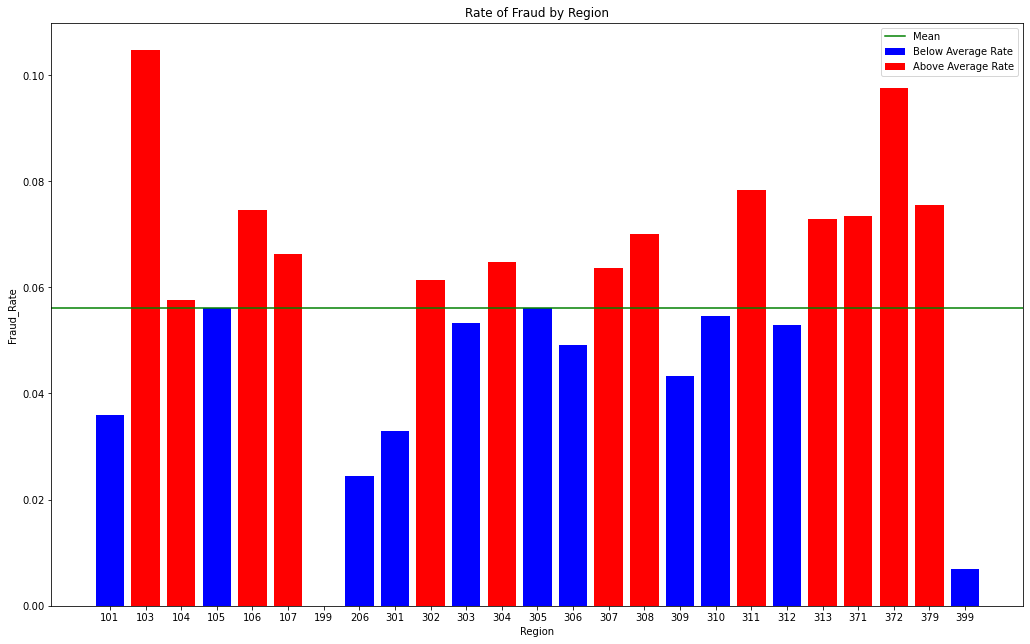

In [152]:
#Region count Plot
region_count_plot = plt.figure(figsize = (15,9))
region_count_axes = region_count_plot.add_axes([0.1,0.1,0.9,0.9])
region_count_axes.set_xlabel('Region')
region_count_axes.set_ylabel('Fraud_Rate')
region_count_axes.set_title('Rate of Fraud by Region')

reg = [str(a) for a in fraud_region_count['region'].tolist()]
rate = fraud_region_count['fraud_rate'].tolist()
for i in range(25):
    colour = 'b'
    lab = 'Below Average Rate'
    if rate[i] > fraud_rate_mean:
        high_risk_regions.append(reg[i])
        colour = 'r'
        lab = 'Above Average Rate'
    region_count_axes.bar(reg[i],rate[i], color = colour, label = lab)
region_count_axes.axhline(y=fraud_rate_mean, color="g", label = 'Mean')
region_count_axes.legend()
handles, labels = region_count_axes.get_legend_handles_labels()  
lgd = dict(zip(labels, handles))
region_count_axes.legend(lgd.values(), lgd.keys())

### Fraud Count by District

In [153]:
all_district_count = client_train[['disrict','target']].groupby('disrict').count().reset_index().sort_values(by=['disrict'])
fraud_district_count = frauds_client[['disrict','target']].groupby('disrict').count().reset_index()
print(all_district_count.shape,
fraud_district_count.shape)

(4, 2) (4, 2)


In [154]:
all_d_count = all_district_count['target'].tolist()
fraud_d_count = fraud_district_count['target'].tolist()
fraud_d_rate = [fraud_d_count[i]/all_d_count[i] for i in range(len(all_d_count))]
fraud_district_count['fraud_rate'] = fraud_d_rate
fraud_district_count = fraud_district_count.reset_index(drop = True)
med_fraud_district = fraud_district_count['fraud_rate'].median()
fraud_district_count

,disrict,target,fraud_rate
0,60,913,0.035848
1,62,1670,0.051762
2,63,1516,0.065123
3,69,1987,0.072563


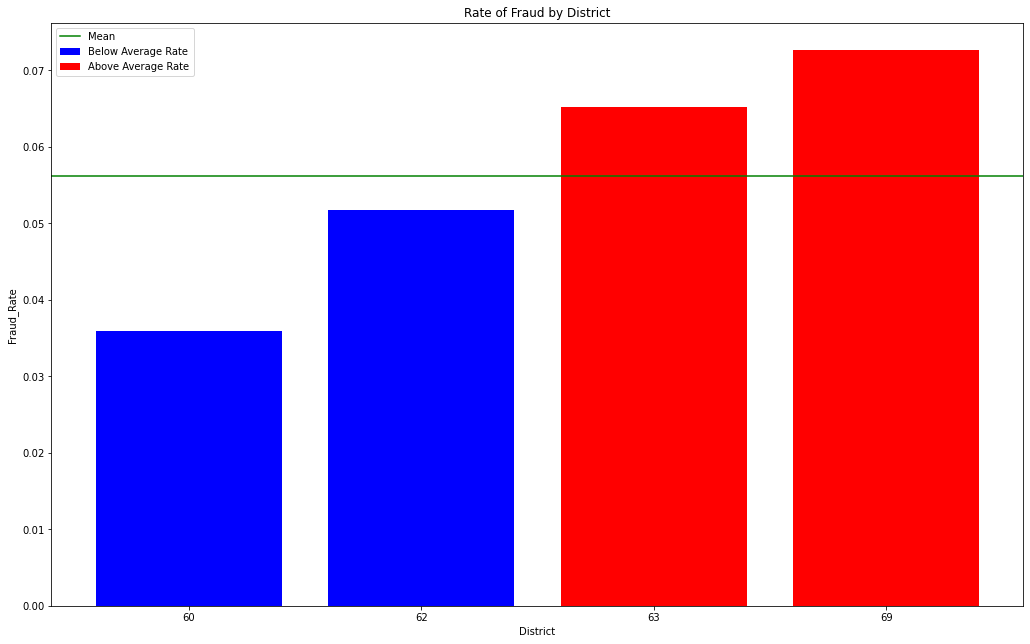

In [155]:
#District count plot
district_count_plot = plt.figure(figsize = (15,9))
district_count_axes = district_count_plot.add_axes([0.1,0.1,0.9,0.9])
district_count_axes.set_xlabel('District')
district_count_axes.set_ylabel('Fraud_Rate')
district_count_axes.set_title('Rate of Fraud by District')

reg = [str(a) for a in fraud_district_count['disrict'].tolist()]
rate = fraud_district_count['fraud_rate'].tolist()
for i in range(4):
    colour = 'b'
    lab = 'Below Average Rate'
    if rate[i] > fraud_rate_mean:
        high_risk_districts.append(reg[i])
        colour = 'r'
        lab = 'Above Average Rate'
    district_count_axes.bar(reg[i],rate[i], color = colour, label = lab)
district_count_axes.axhline(y=fraud_rate_mean, color="g", label = 'Median')
district_count_axes.legend()
handles, labels = region_count_axes.get_legend_handles_labels()  
lgd = dict(zip(labels, handles))
district_count_axes.legend(lgd.values(), lgd.keys())

### Analysing feature crosses for district and region


In [156]:
location_crosses = client_train.groupby(['region','disrict']).count().reset_index()[['region','disrict','target']].sort_values('region')
location_crosses_region = location_crosses['region'].tolist()
location_crosses_district = location_crosses['disrict'].tolist()
location_crosses_unique = [(location_crosses_region[i], location_crosses_district[i]) for i in range(len(location_crosses_region))]
fraud_location_crosses = frauds_client.groupby(['region','disrict']).count().reset_index()[['region','disrict','target']].sort_values('region')
fraud_location_crosses_region = fraud_location_crosses['region'].tolist()
fraud_location_crosses_district = fraud_location_crosses['disrict'].tolist()
fraud_location_crosses_unique = [(fraud_location_crosses_region[i], fraud_location_crosses_district[i]) for i in range(len(fraud_location_crosses_region))]
fraud_location_crosses['location'] = fraud_location_crosses_unique
df = pd.DataFrame()
for i in range(len(location_crosses_region)):
    if location_crosses_unique[i] not in fraud_location_crosses_unique:
        df = df.append({'region': location_crosses_region[i]
                    ,'disrict':location_crosses_district[i]
                    ,'target' : 0
                    ,'location': (location_crosses_region[i],location_crosses_district[i])}, ignore_index=True)

fraud_location_crosses = pd.concat([df,fraud_location_crosses]).sort_values('region').reset_index(drop = True)
location_crosses_count = location_crosses['target'].tolist()
fraud_location_crosses_count = fraud_location_crosses['target'].tolist()
location_crosses_fraud_rate = [fraud_location_crosses_count[i]/location_crosses_count[i] for i in range(len(location_crosses_count))]
fraud_location_crosses['fraud_rate'] = location_crosses_fraud_rate
fraud_location_crosses

C:\Users\Keltonn Lim\AppData\Local\Temp\ipykernel_4348\623523154.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'region': location_crosses_region[i]
C:\Users\Keltonn Lim\AppData\Local\Temp\ipykernel_4348\623523154.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'region': location_crosses_region[i]
C:\Users\Keltonn Lim\AppData\Local\Temp\ipykernel_4348\623523154.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'region': location_crosses_region[i]
C:\Users\Keltonn Lim\AppData\Local\Temp\ipykernel_4348\623523154.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.appen

,region,disrict,target,location,fraud_rate
0,101,60,913,"(101, 60)",0.035850
1,101,63,57,"(101, 63)",0.038204
2,103,69,744,"(103, 69)",0.104627
3,104,69,595,"(104, 69)",0.057605
4,105,69,74,"(105, 69)",0.056018
5,106,69,42,"(106, 69)",0.074600
6,107,69,531,"(107, 69)",0.066226
7,199,60,0,"(199, 60)",0.000000
8,206,69,1,"(206, 69)",0.024390
9,301,62,251,"(301, 62)",0.032909


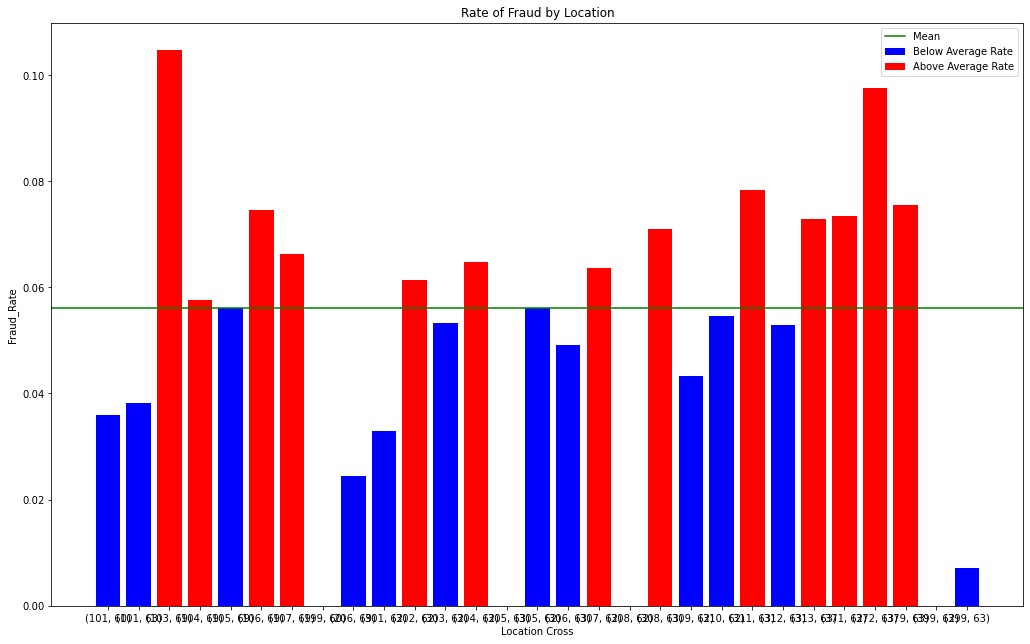

In [157]:
#Location Cross count plot
location_cross_plot = plt.figure(figsize = (15,9))
location_cross_axes = location_cross_plot.add_axes([0.1,0.1,0.9,0.9])
location_cross_axes.set_xlabel('Location Cross')
location_cross_axes.set_ylabel('Fraud_Rate')
location_cross_axes.set_title('Rate of Fraud by Location')

reg = [str(a) for a in fraud_location_crosses['location'].tolist()]
rate = fraud_location_crosses['fraud_rate'].tolist()
for i in range(len(reg)):
    colour = 'b'
    lab = 'Below Average Rate'
    if rate[i] > fraud_rate_mean:
        colour = 'r'
        lab = 'Above Average Rate'
    location_cross_axes.bar(reg[i],rate[i], color = colour, label = lab)
location_cross_axes.axhline(y=fraud_rate_mean, color="g", label = 'Mean')
location_cross_axes.legend()
handles, labels = region_count_axes.get_legend_handles_labels()  
lgd = dict(zip(labels, handles))
location_cross_axes.legend(lgd.values(), lgd.keys())

### Dimensionality Reduction by classifying location into high and low risk

In [158]:
post_bucket_columns = ['disrict', 'client_id', 'region', 'creation_date',
       'client_catg_11', 'client_catg_12', 'client_catg_51', 'target']


input_train = client_train[post_bucket_columns].copy()
input_test = client_test[post_bucket_columns].copy()
input_val = client_val[post_bucket_columns].copy()

for dataset in (input_train, input_test, input_val):
    dataset['high_risk_region'] = dataset['region'].apply(lambda x: 1 if (str(x) in high_risk_regions) else 0)
    dataset['high_risk_district'] = dataset['disrict'].apply(lambda x: 1 if (str(x) in high_risk_districts) else 0)

input_train = input_train.drop(['disrict','region'], axis=1)
input_test = input_test.drop(['disrict','region'], axis=1)
input_val = input_val.drop(['disrict','region'], axis=1)

In [159]:
input_train

,client_id,creation_date,client_catg_11,client_catg_12,client_catg_51,target,high_risk_region,high_risk_district
0,train_Client_44618,30/11/2018,1,0,0,0.0,0,1
1,train_Client_118743,06/03/1992,1,0,0,0.0,0,0
2,train_Client_902,04/12/1992,1,0,0,0.0,0,1
3,train_Client_38892,04/03/2011,1,0,0,0.0,1,1
4,train_Client_12217,13/02/2012,1,0,0,0.0,0,1
...,...,...,...,...,...,...,...,...
108389,train_Client_44068,22/02/2018,1,0,0,0.0,0,0
108390,train_Client_76388,17/05/1977,1,0,0,0.0,0,0
108391,train_Client_23104,16/11/2015,1,0,0,0.0,1,1
108392,train_Client_10467,04/09/1992,1,0,0,0.0,1,1


In [160]:
input_test

,client_id,creation_date,client_catg_11,client_catg_12,client_catg_51,target,high_risk_region,high_risk_district
0,train_Client_70981,10/03/2004,1,0,0,0.0,0,0
1,train_Client_57734,12/01/2008,1,0,0,0.0,0,0
2,train_Client_69352,23/04/2013,1,0,0,0.0,1,0
3,train_Client_22916,11/03/2017,1,0,0,0.0,0,0
4,train_Client_97185,01/11/2013,1,0,0,0.0,1,1
...,...,...,...,...,...,...,...,...
13544,train_Client_66414,05/09/2014,1,0,0,0.0,0,1
13545,train_Client_108654,26/05/2008,1,0,0,0.0,0,0
13546,train_Client_118649,19/10/2017,1,0,0,0.0,1,1
13547,train_Client_126011,28/06/1991,1,0,0,1.0,0,0


In [161]:
input_val

,client_id,creation_date,client_catg_11,client_catg_12,client_catg_51,target,high_risk_region,high_risk_district
0,train_Client_35772,20/12/2001,1,0,0,0.0,0,0
1,train_Client_83696,15/06/2015,1,0,0,0.0,1,1
2,train_Client_106451,11/05/2009,1,0,0,0.0,1,1
3,train_Client_44003,12/11/1997,1,0,0,0.0,0,0
4,train_Client_45500,07/04/1987,1,0,0,0.0,1,1
...,...,...,...,...,...,...,...,...
13545,train_Client_116897,27/09/2001,1,0,0,0.0,0,0
13546,train_Client_79098,07/05/2002,0,0,1,0.0,0,1
13547,train_Client_59337,17/05/2011,1,0,0,0.0,0,0
13548,train_Client_77834,30/12/1985,1,0,0,0.0,1,1


### Datetime Analysis

Based on our exploration, the day and month of account creation does not show a clear correlation to the rate of fraud. As such, we will be dropping any time based features from the input.

Since we cannot assume that the test/validaiton dataset exist within the same year range as the training dataset, we will also exclude year by default.

In [162]:
apc = client_train[['client_id','target']]
apc_id = apc['client_id'].tolist()
apc_target = apc['target'].tolist()
mapper = {}

for i in range(len(apc)):
    mapper[apc_id[i]] = apc_target[i]

In [163]:
invoice_train['target'] = invoice_train['client_id'].apply(lambda x: mapper[x])

In [164]:
# Client Datetime Processing
input_train['day'] = input_train['creation_date'].apply(lambda x: x.split('/')[0])
input_train['month_of_year'] = input_train['creation_date'].apply(lambda x: x.split('/')[1])

In [165]:
apc = input_train[input_train['target']== 1].groupby(['month_of_year']).count()['client_id'].reset_index()
apc2 =  input_train.groupby(['month_of_year']).count()['client_id'].reset_index()
months = apc['month_of_year'].tolist()
frauds = apc['client_id'].tolist()
total_clients = apc2['client_id'].tolist() 
rates = []
for i in range(len(frauds)):
    rates.append(frauds[i]/total_clients[i])

<BarContainer object of 12 artists>

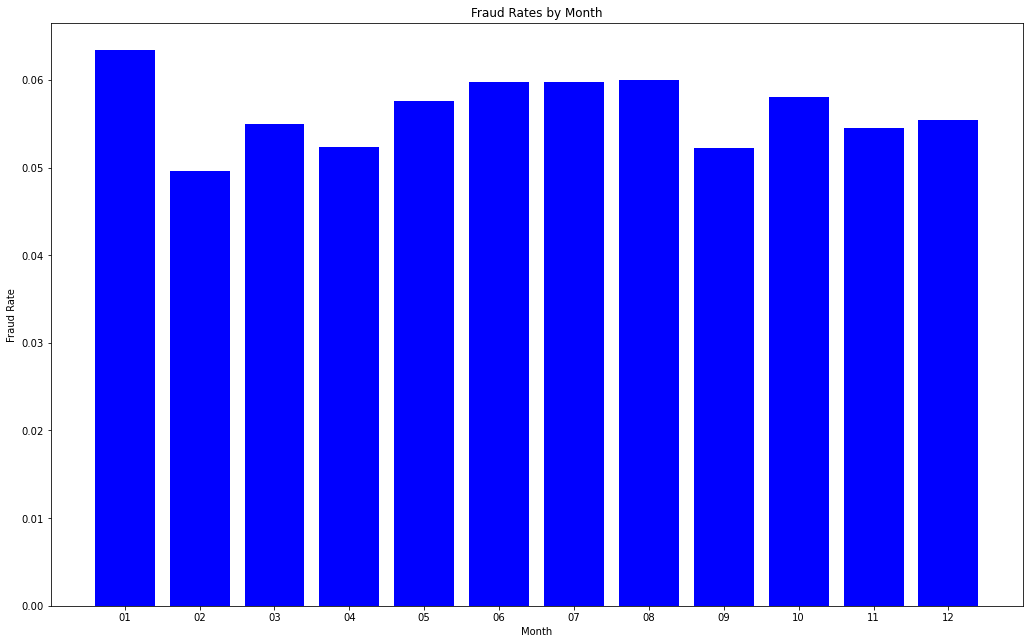

In [166]:
pl = plt.figure(figsize = (15,9))
ax = pl.add_axes([0.1,0.1,0.9,0.9])
ax.set_xlabel('Month')
ax.set_ylabel('Fraud Rate')
ax.set_title('Fraud Rates by Month')
ax.bar(months,rates, color = 'blue')

In [167]:
apc = input_train[input_train['target']== 1].groupby(['day']).count()['client_id'].reset_index()
apc2 =  input_train.groupby(['day']).count()['client_id'].reset_index()
day = apc['day'].tolist()
frauds = apc['client_id'].tolist()
total_clients = apc2['client_id'].tolist() 
rates = []
for i in range(len(frauds)):
    rates.append(frauds[i]/total_clients[i])

<BarContainer object of 31 artists>

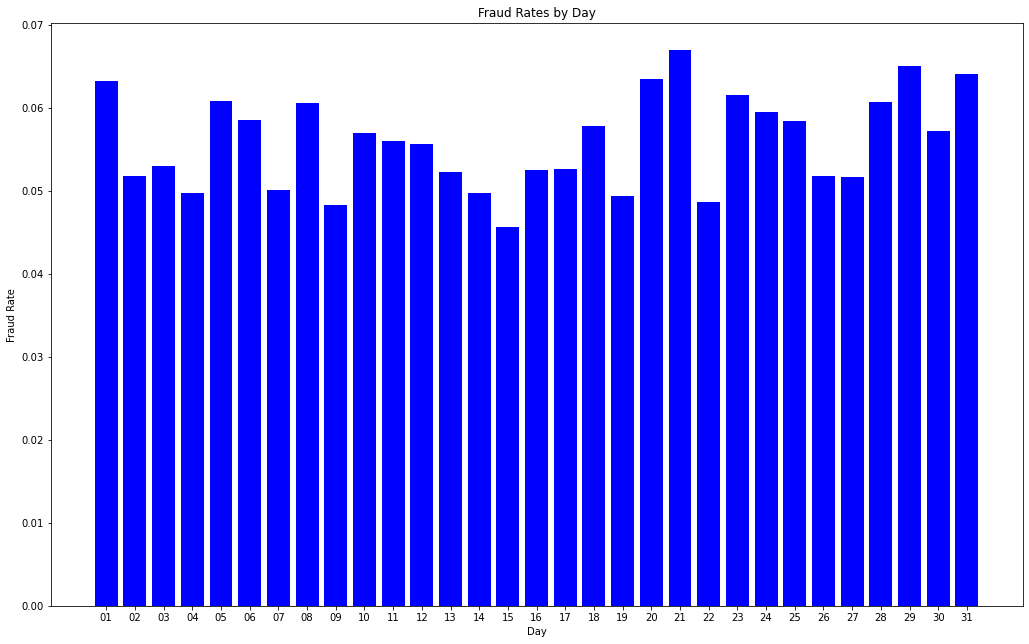

In [168]:
pl = plt.figure(figsize = (15,9))
ax = pl.add_axes([0.1,0.1,0.9,0.9])
ax.set_xlabel('Day')
ax.set_ylabel('Fraud Rate')
ax.set_title('Fraud Rates by Day')
ax.bar(day,rates, color = 'blue')

In [169]:
input_train = input_train.drop(['day','month_of_year','creation_date'], axis=1)
input_train

,client_id,client_catg_11,client_catg_12,client_catg_51,target,high_risk_region,high_risk_district
0,train_Client_44618,1,0,0,0.0,0,1
1,train_Client_118743,1,0,0,0.0,0,0
2,train_Client_902,1,0,0,0.0,0,1
3,train_Client_38892,1,0,0,0.0,1,1
4,train_Client_12217,1,0,0,0.0,0,1
...,...,...,...,...,...,...,...
108389,train_Client_44068,1,0,0,0.0,0,0
108390,train_Client_76388,1,0,0,0.0,0,0
108391,train_Client_23104,1,0,0,0.0,1,1
108392,train_Client_10467,1,0,0,0.0,1,1


In [170]:
input_test = input_test.drop('creation_date', axis = 1)
input_test

,client_id,client_catg_11,client_catg_12,client_catg_51,target,high_risk_region,high_risk_district
0,train_Client_70981,1,0,0,0.0,0,0
1,train_Client_57734,1,0,0,0.0,0,0
2,train_Client_69352,1,0,0,0.0,1,0
3,train_Client_22916,1,0,0,0.0,0,0
4,train_Client_97185,1,0,0,0.0,1,1
...,...,...,...,...,...,...,...
13544,train_Client_66414,1,0,0,0.0,0,1
13545,train_Client_108654,1,0,0,0.0,0,0
13546,train_Client_118649,1,0,0,0.0,1,1
13547,train_Client_126011,1,0,0,1.0,0,0


In [171]:
input_val = input_val.drop('creation_date', axis = 1)
input_val

,client_id,client_catg_11,client_catg_12,client_catg_51,target,high_risk_region,high_risk_district
0,train_Client_35772,1,0,0,0.0,0,0
1,train_Client_83696,1,0,0,0.0,1,1
2,train_Client_106451,1,0,0,0.0,1,1
3,train_Client_44003,1,0,0,0.0,0,0
4,train_Client_45500,1,0,0,0.0,1,1
...,...,...,...,...,...,...,...
13545,train_Client_116897,1,0,0,0.0,0,0
13546,train_Client_79098,0,0,1,0.0,0,1
13547,train_Client_59337,1,0,0,0.0,0,0
13548,train_Client_77834,1,0,0,0.0,1,1


### Counter Status Analysis
There are 6 unique counter status values, from 0 to 5. Based on our analysis below, clients using counters that have more varied statuses tend to have a higher rate of fraud. In other words, if a client's counter consistently changes in operational status, the client has a higher chance of fraudlent behaviour.

In [172]:
unique_status_count = invoice_train.groupby(['client_id'])['counter_statue'].nunique().reset_index()
unique_status_count['target'] =  unique_status_count['client_id'].apply(lambda x: mapper[x])
unique_status_count_fraud = unique_status_count[unique_status_count['target'] == 1]
clients_by_statuses = unique_status_count.groupby('counter_statue').count().reset_index()
clients_by_statuses_fraud = unique_status_count_fraud.groupby('counter_statue').count().reset_index()
idx = [str(i) for i in clients_by_statuses['counter_statue'].tolist()]
vals = [clients_by_statuses_fraud['target'].tolist()[i]/clients_by_statuses['target'].tolist()[i] for i in range(len(clients_by_statuses_fraud))]

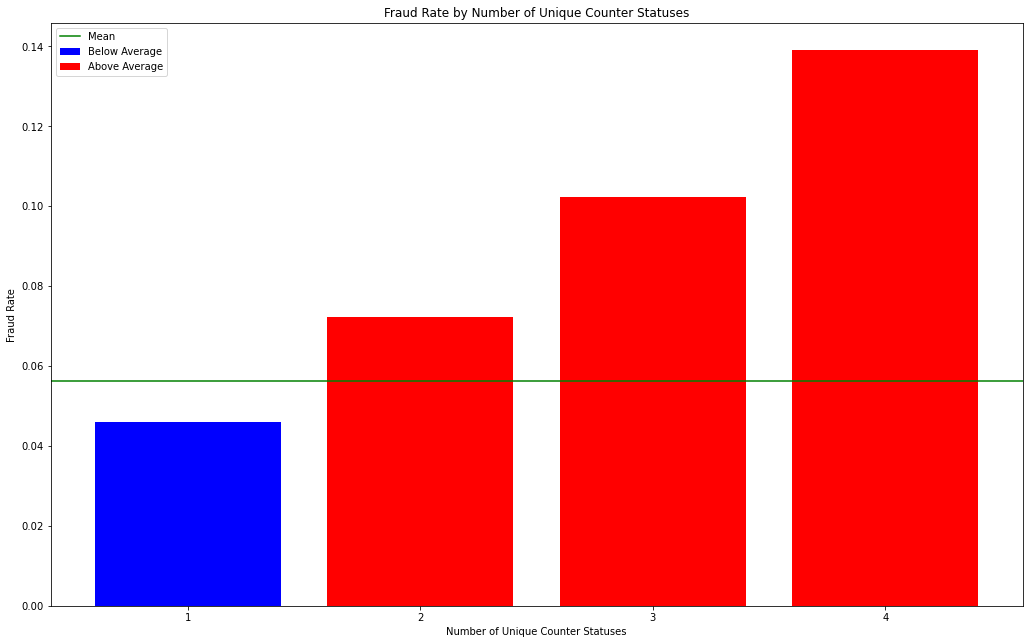

In [173]:
pl = plt.figure(figsize = (15,9))
ax = pl.add_axes([0.1,0.1,0.9,0.9])
ax.set_xlabel('Number of Unique Counter Statuses')
ax.set_ylabel('Fraud Rate')
ax.set_title('Fraud Rate by Number of Unique Counter Statuses')
for i in range(len(idx)):
  if vals[i] <fraud_rate_mean:
    ax.bar(idx[i], vals[i], color = 'blue', label = 'Below Average')
  else:
    ax.bar(idx[i], vals[i], color = 'red', label = 'Above Average')
ax.axhline(y=fraud_rate_mean, color="g", label = 'Mean')
ax.legend()
handles, labels = ax.get_legend_handles_labels()  
lgd = dict(zip(labels, handles))
ax.legend(lgd.values(), lgd.keys())

Since there are up to 6 distinct statuses, that means that any single customer can have up to 6 differing statuses in their invoice history. However, the dataset does not include these cases. This means that any customer in the test or validation data with 5 or 6 distinct counter statuses in their transaction history may not be properly classified if we simply performed one hot encoding.

To circumnavigate this, we perform bucketing once more. Clients with only 1 unique counter status in their invoice history will be considered `low_risk`. Clients with 3 or more unique statuses will be classified `high risk`.

The reason why we chose to include clients with 3 unique statuses under `high risk` was due to sample size. There are only 36 clients with 4 or more unique statuses, representing less than 1% of the total data set.

In [174]:
unique_status_count.groupby('counter_statue').count()

,client_id,target
counter_statue,,
1,73981,73981
2,27792,27792
3,6585,6585
4,36,36


In [175]:
client_status_map = {}
clients = unique_status_count['client_id'].tolist()
status_counts = unique_status_count['counter_statue'].tolist()
for i in range(len(clients)):
    client_status_map[clients[i]] = status_counts[i]

input_train['counter_status_low_risk'] = input_train['client_id'].apply(lambda x: 1 if (client_status_map[x] == 1) else 0)
input_train['counter_status_high_risk'] = input_train['client_id'].apply(lambda x: 1 if (client_status_map[x] >= 3) else 0)

In [176]:
input_train

,client_id,client_catg_11,client_catg_12,client_catg_51,target,high_risk_region,high_risk_district,counter_status_low_risk,counter_status_high_risk
0,train_Client_44618,1,0,0,0.0,0,1,1,0
1,train_Client_118743,1,0,0,0.0,0,0,1,0
2,train_Client_902,1,0,0,0.0,0,1,0,0
3,train_Client_38892,1,0,0,0.0,1,1,0,1
4,train_Client_12217,1,0,0,0.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
108389,train_Client_44068,1,0,0,0.0,0,0,1,0
108390,train_Client_76388,1,0,0,0.0,0,0,1,0
108391,train_Client_23104,1,0,0,0.0,1,1,1,0
108392,train_Client_10467,1,0,0,0.0,1,1,0,1


In [177]:
client_status_map = {}
unique_status_count = invoice_test.groupby(['client_id'])['counter_statue'].nunique().reset_index()
clients = unique_status_count['client_id'].tolist()
status_counts = unique_status_count['counter_statue'].tolist()
for i in range(len(clients)):
    client_status_map[clients[i]] = status_counts[i]

input_test['counter_status_low_risk'] = input_test['client_id'].apply(lambda x: 1 if (client_status_map[x] == 1) else 0)
input_test['counter_status_high_risk'] = input_test['client_id'].apply(lambda x: 1 if (client_status_map[x] >= 3) else 0)
input_test

,client_id,client_catg_11,client_catg_12,client_catg_51,target,high_risk_region,high_risk_district,counter_status_low_risk,counter_status_high_risk
0,train_Client_70981,1,0,0,0.0,0,0,0,0
1,train_Client_57734,1,0,0,0.0,0,0,1,0
2,train_Client_69352,1,0,0,0.0,1,0,0,0
3,train_Client_22916,1,0,0,0.0,0,0,1,0
4,train_Client_97185,1,0,0,0.0,1,1,1,0
...,...,...,...,...,...,...,...,...,...
13544,train_Client_66414,1,0,0,0.0,0,1,1,0
13545,train_Client_108654,1,0,0,0.0,0,0,0,0
13546,train_Client_118649,1,0,0,0.0,1,1,1,0
13547,train_Client_126011,1,0,0,1.0,0,0,0,0


In [178]:
client_status_map = {}
unique_status_count = invoice_val.groupby(['client_id'])['counter_statue'].nunique().reset_index()
clients = unique_status_count['client_id'].tolist()
status_counts = unique_status_count['counter_statue'].tolist()
for i in range(len(clients)):
    client_status_map[clients[i]] = status_counts[i]

input_val['counter_status_low_risk'] = input_val['client_id'].apply(lambda x: 1 if (client_status_map[x] == 1) else 0)
input_val['counter_status_high_risk'] = input_val['client_id'].apply(lambda x: 1 if (client_status_map[x] >= 3) else 0)
input_val

,client_id,client_catg_11,client_catg_12,client_catg_51,target,high_risk_region,high_risk_district,counter_status_low_risk,counter_status_high_risk
0,train_Client_35772,1,0,0,0.0,0,0,1,0
1,train_Client_83696,1,0,0,0.0,1,1,1,0
2,train_Client_106451,1,0,0,0.0,1,1,1,0
3,train_Client_44003,1,0,0,0.0,0,0,1,0
4,train_Client_45500,1,0,0,0.0,1,1,1,0
...,...,...,...,...,...,...,...,...,...
13545,train_Client_116897,1,0,0,0.0,0,0,1,0
13546,train_Client_79098,0,0,1,0.0,0,1,1,0
13547,train_Client_59337,1,0,0,0.0,0,0,1,0
13548,train_Client_77834,1,0,0,0.0,1,1,1,0


### Tariff Type Analysis

We performed the same analysis on Tariff type. Again, we see a similar pattern. Customers with more different types of tariffs have higher rates of fraud. One hypothesis here to explain this observation was that fraud customers would try to siphon gas or electricity from different counters in different areas in order to mask their actual location, or try to minimise costs or maximise returns.

Again, bucketising this field is necessary as the training data does not capture all possible combinations of Tariff Types. There are a total of 19 tariff types, but the dataset only contains clients who use up to 6 unique tariffs at any one point in time. This means that an outlier client with 7 or more tariffs in their invoice history may not be properly classified if we used one hot encoding.

In [179]:
tarif = invoice_train.groupby(['client_id'])['tarif_type'].nunique().reset_index()
number_of_clients = tarif.groupby('tarif_type').count()['client_id'].tolist()
unique_tariffs = [str(i) for i in tarif.groupby('tarif_type').count()['client_id'].reset_index()['tarif_type'].tolist()]

tarif2 = invoice_train[invoice_train['target'] == 1].groupby(['client_id'])['tarif_type'].nunique().reset_index()
number_of_clients_fraud = tarif2.groupby('tarif_type').count()['client_id'].tolist()
tariff_fraud_rates = [number_of_clients_fraud[i]/number_of_clients[i] for i in range(len(number_of_clients))]

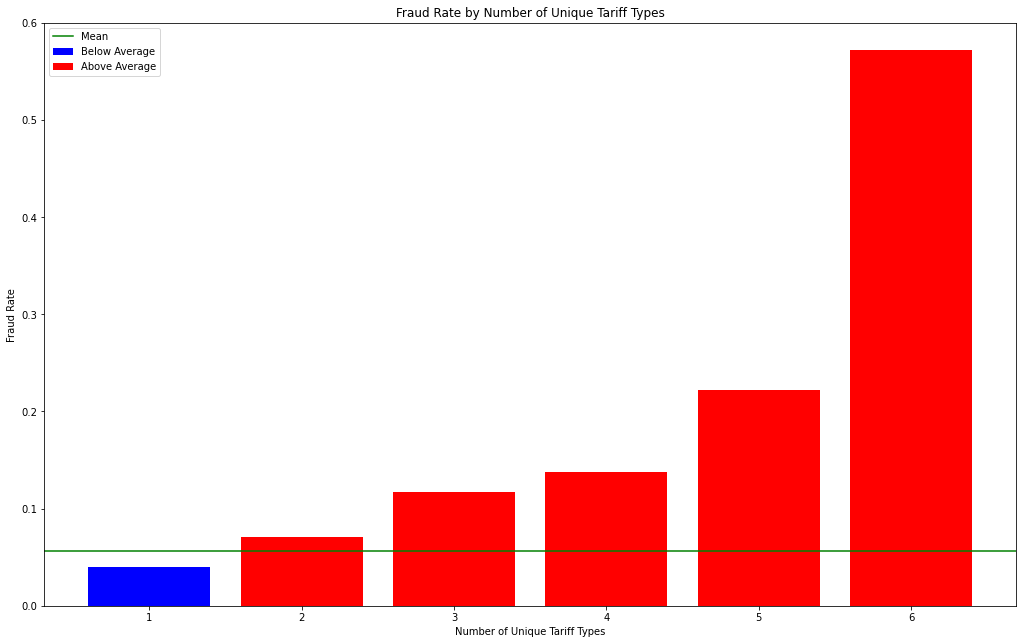

In [180]:
pl = plt.figure(figsize = (15,9))
ax = pl.add_axes([0.1,0.1,0.9,0.9])
ax.set_xlabel('Number of Unique Tariff Types')
ax.set_ylabel('Fraud Rate')
ax.set_title('Fraud Rate by Number of Unique Tariff Types')
for i in range(len(tariff_fraud_rates)):
  if tariff_fraud_rates[i] <fraud_rate_mean:
    ax.bar(unique_tariffs[i],tariff_fraud_rates[i], color = 'blue', label = 'Below Average')
  else:
    ax.bar(unique_tariffs[i],tariff_fraud_rates[i], color = 'red', label = 'Above Average')
ax.axhline(y=fraud_rate_mean, color="g", label = 'Mean')
ax.legend()
handles, labels = ax.get_legend_handles_labels()
lgd = dict(zip(labels, handles))
ax.legend(lgd.values(), lgd.keys())

In [181]:
client_tariff_map = {}
clients = tarif['client_id'].tolist()
tariff_counts = tarif['tarif_type'].tolist()
for i in range(len(clients)):
    client_tariff_map[clients[i]] = tariff_counts[i]
input_train['tarif_low_risk'] = input_train['client_id'].apply(lambda x: 1 if (client_tariff_map[x] == 1) else 0)
input_train['tarif_high_risk'] = input_train['client_id'].apply(lambda x: 1 if (client_tariff_map[x] >= 5) else 0)
input_train

,client_id,client_catg_11,client_catg_12,client_catg_51,target,high_risk_region,high_risk_district,counter_status_low_risk,counter_status_high_risk,tarif_low_risk,tarif_high_risk
0,train_Client_44618,1,0,0,0.0,0,1,1,0,1,0
1,train_Client_118743,1,0,0,0.0,0,0,1,0,1,0
2,train_Client_902,1,0,0,0.0,0,1,0,0,0,0
3,train_Client_38892,1,0,0,0.0,1,1,0,1,0,0
4,train_Client_12217,1,0,0,0.0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
108389,train_Client_44068,1,0,0,0.0,0,0,1,0,1,0
108390,train_Client_76388,1,0,0,0.0,0,0,1,0,1,0
108391,train_Client_23104,1,0,0,0.0,1,1,1,0,1,0
108392,train_Client_10467,1,0,0,0.0,1,1,0,1,0,0


In [182]:
client_tariff_map = {}
tarif = invoice_test.groupby(['client_id'])['tarif_type'].nunique().reset_index()
clients = tarif['client_id'].tolist()
tariff_counts = tarif['tarif_type'].tolist()
for i in range(len(clients)):
    client_tariff_map[clients[i]] = tariff_counts[i]
input_test['tarif_low_risk'] = input_test['client_id'].apply(lambda x: 1 if (client_tariff_map[x] == 1) else 0)
input_test['tarif_high_risk'] = input_test['client_id'].apply(lambda x: 1 if (client_tariff_map[x] >= 5) else 0)
input_test

,client_id,client_catg_11,client_catg_12,client_catg_51,target,high_risk_region,high_risk_district,counter_status_low_risk,counter_status_high_risk,tarif_low_risk,tarif_high_risk
0,train_Client_70981,1,0,0,0.0,0,0,0,0,0,0
1,train_Client_57734,1,0,0,0.0,0,0,1,0,1,0
2,train_Client_69352,1,0,0,0.0,1,0,0,0,0,0
3,train_Client_22916,1,0,0,0.0,0,0,1,0,1,0
4,train_Client_97185,1,0,0,0.0,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
13544,train_Client_66414,1,0,0,0.0,0,1,1,0,0,0
13545,train_Client_108654,1,0,0,0.0,0,0,0,0,1,0
13546,train_Client_118649,1,0,0,0.0,1,1,1,0,1,0
13547,train_Client_126011,1,0,0,1.0,0,0,0,0,0,0


In [183]:
client_tariff_map = {}
tarif = invoice_val.groupby(['client_id'])['tarif_type'].nunique().reset_index()
clients = tarif['client_id'].tolist()
tariff_counts = tarif['tarif_type'].tolist()
for i in range(len(clients)):
    client_tariff_map[clients[i]] = tariff_counts[i]
input_val['tarif_low_risk'] = input_val['client_id'].apply(lambda x: 1 if (client_tariff_map[x] == 1) else 0)
input_val['tarif_high_risk'] = input_val['client_id'].apply(lambda x: 1 if (client_tariff_map[x] >= 5) else 0)
input_val

,client_id,client_catg_11,client_catg_12,client_catg_51,target,high_risk_region,high_risk_district,counter_status_low_risk,counter_status_high_risk,tarif_low_risk,tarif_high_risk
0,train_Client_35772,1,0,0,0.0,0,0,1,0,1,0
1,train_Client_83696,1,0,0,0.0,1,1,1,0,1,0
2,train_Client_106451,1,0,0,0.0,1,1,1,0,0,0
3,train_Client_44003,1,0,0,0.0,0,0,1,0,1,0
4,train_Client_45500,1,0,0,0.0,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
13545,train_Client_116897,1,0,0,0.0,0,0,1,0,1,0
13546,train_Client_79098,0,0,1,0.0,0,1,1,0,1,0
13547,train_Client_59337,1,0,0,0.0,0,0,1,0,1,0
13548,train_Client_77834,1,0,0,0.0,1,1,1,0,1,0


### Reading Remarks Analysis

In [184]:
remarks = invoice_train.groupby(['client_id','reading_remarque']).count().reset_index()[['client_id','reading_remarque']]
remarks_id = remarks['client_id'].tolist()
remarks_reading = remarks['reading_remarque'].tolist()
remarks_encoder = {}
for i in range(len(remarks_id)):
    if remarks_id[i] not in remarks_encoder:
        remarks_encoder[remarks_id[i]] = []
    remarks_encoder[remarks_id[i]].append(remarks_reading[i])

input_train['reading_6'] = input_train['client_id'].apply(lambda x: 1 if (6 in remarks_encoder[x]) else 0)
input_train['reading_7'] = input_train['client_id'].apply(lambda x: 1 if (7 in remarks_encoder[x]) else 0)
input_train['reading_8'] = input_train['client_id'].apply(lambda x: 1 if (8 in remarks_encoder[x]) else 0)
input_train['reading_9'] = input_train['client_id'].apply(lambda x: 1 if (9 in remarks_encoder[x]) else 0)

input_train

,client_id,client_catg_11,client_catg_12,client_catg_51,target,high_risk_region,high_risk_district,counter_status_low_risk,counter_status_high_risk,tarif_low_risk,tarif_high_risk,reading_6,reading_7,reading_8,reading_9
0,train_Client_44618,1,0,0,0.0,0,1,1,0,1,0,0,0,0,1
1,train_Client_118743,1,0,0,0.0,0,0,1,0,1,0,1,0,1,1
2,train_Client_902,1,0,0,0.0,0,1,0,0,0,0,1,0,1,1
3,train_Client_38892,1,0,0,0.0,1,1,0,1,0,0,1,0,1,1
4,train_Client_12217,1,0,0,0.0,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108389,train_Client_44068,1,0,0,0.0,0,0,1,0,1,0,0,0,1,1
108390,train_Client_76388,1,0,0,0.0,0,0,1,0,1,0,1,0,1,1
108391,train_Client_23104,1,0,0,0.0,1,1,1,0,1,0,0,0,1,1
108392,train_Client_10467,1,0,0,0.0,1,1,0,1,0,0,1,0,1,0


In [185]:
remarks = invoice_test.groupby(['client_id','reading_remarque']).count().reset_index()[['client_id','reading_remarque']]
remarks_id = remarks['client_id'].tolist()
remarks_reading = remarks['reading_remarque'].tolist()
remarks_encoder = {}
for i in range(len(remarks_id)):
    if remarks_id[i] not in remarks_encoder:
        remarks_encoder[remarks_id[i]] = []
    remarks_encoder[remarks_id[i]].append(remarks_reading[i])

input_test['reading_6'] = input_test['client_id'].apply(lambda x: 1 if (6 in remarks_encoder[x]) else 0)
input_test['reading_7'] = input_test['client_id'].apply(lambda x: 1 if (7 in remarks_encoder[x]) else 0)
input_test['reading_8'] = input_test['client_id'].apply(lambda x: 1 if (8 in remarks_encoder[x]) else 0)
input_test['reading_9'] = input_test['client_id'].apply(lambda x: 1 if (9 in remarks_encoder[x]) else 0)

input_test

,client_id,client_catg_11,client_catg_12,client_catg_51,target,high_risk_region,high_risk_district,counter_status_low_risk,counter_status_high_risk,tarif_low_risk,tarif_high_risk,reading_6,reading_7,reading_8,reading_9
0,train_Client_70981,1,0,0,0.0,0,0,0,0,0,0,1,0,1,1
1,train_Client_57734,1,0,0,0.0,0,0,1,0,1,0,1,0,1,1
2,train_Client_69352,1,0,0,0.0,1,0,0,0,0,0,1,0,0,1
3,train_Client_22916,1,0,0,0.0,0,0,1,0,1,0,1,0,0,1
4,train_Client_97185,1,0,0,0.0,1,1,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13544,train_Client_66414,1,0,0,0.0,0,1,1,0,0,0,1,0,1,1
13545,train_Client_108654,1,0,0,0.0,0,0,0,0,1,0,1,0,1,1
13546,train_Client_118649,1,0,0,0.0,1,1,1,0,1,0,1,0,0,1
13547,train_Client_126011,1,0,0,1.0,0,0,0,0,0,0,1,0,1,1


In [186]:
remarks = invoice_val.groupby(['client_id','reading_remarque']).count().reset_index()[['client_id','reading_remarque']]
remarks_id = remarks['client_id'].tolist()
remarks_reading = remarks['reading_remarque'].tolist()
remarks_encoder = {}
for i in range(len(remarks_id)):
    if remarks_id[i] not in remarks_encoder:
        remarks_encoder[remarks_id[i]] = []
    remarks_encoder[remarks_id[i]].append(remarks_reading[i])

input_val['reading_6'] = input_val['client_id'].apply(lambda x: 1 if (6 in remarks_encoder[x]) else 0)
input_val['reading_7'] = input_val['client_id'].apply(lambda x: 1 if (7 in remarks_encoder[x]) else 0)
input_val['reading_8'] = input_val['client_id'].apply(lambda x: 1 if (8 in remarks_encoder[x]) else 0)
input_val['reading_9'] = input_val['client_id'].apply(lambda x: 1 if (9 in remarks_encoder[x]) else 0)

input_val

,client_id,client_catg_11,client_catg_12,client_catg_51,target,high_risk_region,high_risk_district,counter_status_low_risk,counter_status_high_risk,tarif_low_risk,tarif_high_risk,reading_6,reading_7,reading_8,reading_9
0,train_Client_35772,1,0,0,0.0,0,0,1,0,1,0,1,0,1,1
1,train_Client_83696,1,0,0,0.0,1,1,1,0,1,0,1,0,1,1
2,train_Client_106451,1,0,0,0.0,1,1,1,0,0,0,1,0,0,0
3,train_Client_44003,1,0,0,0.0,0,0,1,0,1,0,1,0,1,1
4,train_Client_45500,1,0,0,0.0,1,1,1,0,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13545,train_Client_116897,1,0,0,0.0,0,0,1,0,1,0,1,0,1,1
13546,train_Client_79098,0,0,1,0.0,0,1,1,0,1,0,1,0,1,0
13547,train_Client_59337,1,0,0,0.0,0,0,1,0,1,0,1,0,1,1
13548,train_Client_77834,1,0,0,0.0,1,1,1,0,1,0,1,0,1,1


### Correlation to consumption trends

We realised that the Honest Customers have consumption values that generally follows more closely to the mean and median values of the total dataset. As such, difference from the group mean could be useful in identifying if a transaction was fraudulent or not.

**Balance the dataset to prevent mean and median bias towards honest customers**

In [187]:
honest_invoices = invoice_train[invoice_train['target']==0]
fraud_invoices = invoice_train[invoice_train['target']==1]
honest_sample = honest_invoices.copy().sample(fraud_invoices.shape[0])
print(honest_sample.shape, fraud_invoices.shape)

(283522, 22) (283522, 22)


In [188]:
balanced_invoices = pd.concat([honest_sample, fraud_invoices.copy()])

**Median**

The Median value of fraud customers falls below the mean of the full dataset, and honest customers have medians higher than the full dataset.

In [189]:
apc2 = honest_invoices.groupby('month_of_year')['consommation_level_1'].median().reset_index()
apc3 = fraud_invoices.groupby('month_of_year')['consommation_level_1'].median().reset_index()
apc4 = balanced_invoices.groupby('month_of_year')['consommation_level_1'].median().reset_index()

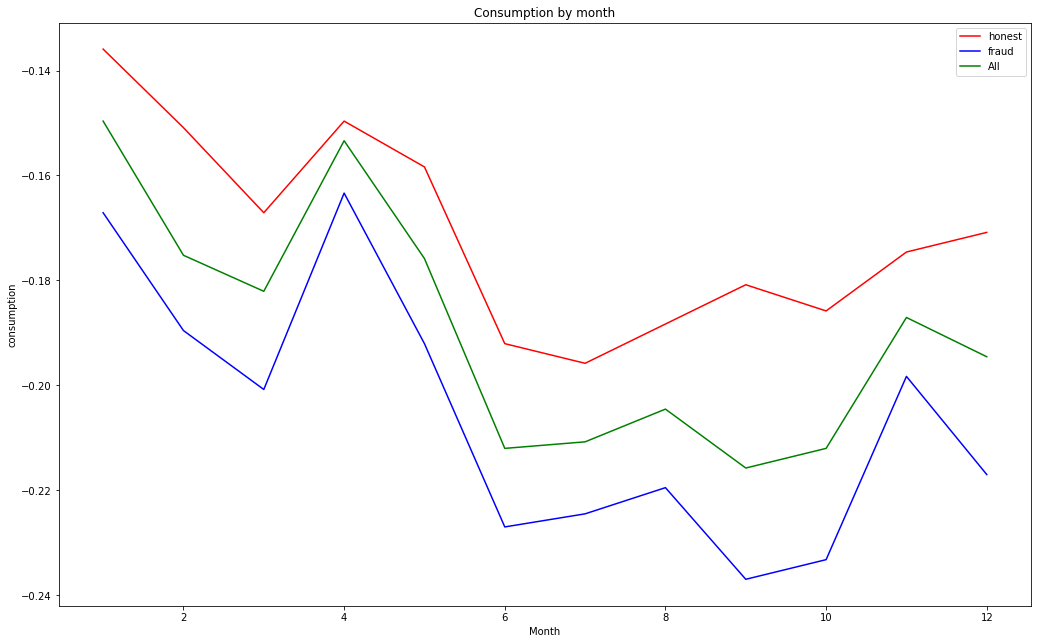

In [190]:
pl = plt.figure(figsize = (15,9))
ax = pl.add_axes([0.1,0.1,0.9,0.9])
ax.set_xlabel('Month')
ax.set_ylabel('consumption')
ax.set_title('Consumption by month')
ax.plot(apc2['month_of_year'],apc2['consommation_level_1'], color = 'red', label = 'honest')
ax.plot(apc3['month_of_year'],apc3['consommation_level_1'], color = 'blue', label = 'fraud')
ax.plot(apc4['month_of_year'],apc4['consommation_level_1'], color = 'green', label = 'All')
ax.legend()

**Mean**

The mean value of honest customers tend to follow the mean of the full dataset more losely than the fraud customers.

In [191]:
apc2 = honest_invoices.groupby('month_of_year')['consommation_level_1'].mean().reset_index()
apc3 = fraud_invoices.groupby('month_of_year')['consommation_level_1'].mean().reset_index()
apc4 = balanced_invoices.groupby('month_of_year')['consommation_level_1'].mean().reset_index()

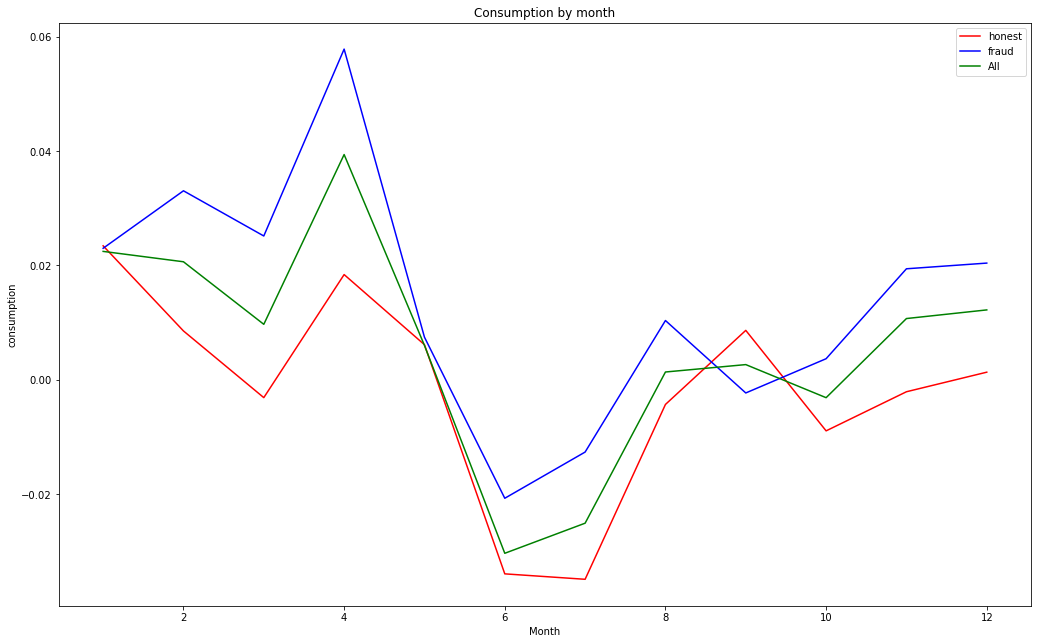

In [192]:
pl = plt.figure(figsize = (15,9))
ax = pl.add_axes([0.1,0.1,0.9,0.9])
ax.set_xlabel('Month')
ax.set_ylabel('consumption')
ax.set_title('Consumption by month')
ax.plot(apc2['month_of_year'],apc2['consommation_level_1'], color = 'red', label = 'honest')
ax.plot(apc3['month_of_year'],apc3['consommation_level_1'], color = 'blue', label = 'fraud')
ax.plot(apc4['month_of_year'],apc4['consommation_level_1'], color = 'green', label = 'All')
ax.legend()

**Taking difference from mean for each sample**

In [193]:
con_stats = invoice_train.groupby(['month_of_year','year','tarif_type'])['consommation_level_1'].mean().reset_index()
con_stats['consommation_level_1'] = con_stats['consommation_level_1'].apply(lambda x: round(x, 4))
con_stats.columns= ['month_of_year', 'year', 'tarif_type', 'consume_mean']
con_stats

,month_of_year,year,tarif_type,consume_mean
0,1,1978,10,-0.1521
1,1,1979,10,-0.4360
2,1,1980,10,-0.2669
3,1,1980,11,-0.5140
4,1,1981,10,-0.4468
...,...,...,...,...
3271,12,2019,14,0.4724
3272,12,2019,15,-0.4871
3273,12,2019,29,0.1386
3274,12,2019,40,-0.2473


In [194]:
con_temp = invoice_train.groupby(['client_id','month_of_year','year','tarif_type'])['consommation_level_1'].mean().reset_index()
con_temp['consommation_level_1'] = con_temp['consommation_level_1'].apply(lambda x: round(x, 4))
con_temp

,client_id,month_of_year,year,tarif_type,consommation_level_1
0,train_Client_0,1,2008,11,-0.1684
1,train_Client_0,1,2009,11,-0.1209
2,train_Client_0,2,2006,11,-0.3380
3,train_Client_0,2,2007,11,-0.2869
4,train_Client_0,2,2013,11,-0.4666
...,...,...,...,...,...
3389728,train_Client_99996,10,2017,40,-0.4117
3389729,train_Client_99996,10,2018,11,0.3320
3389730,train_Client_99996,10,2018,40,-0.3755
3389731,train_Client_99998,8,2005,10,-0.0149


In [195]:
consume_stats = pd.merge(con_temp,con_stats,on=['month_of_year','year','tarif_type'],how='left')
consume_stats

,client_id,month_of_year,year,tarif_type,consommation_level_1,consume_mean
0,train_Client_0,1,2008,11,-0.1684,0.1816
1,train_Client_0,1,2009,11,-0.1209,0.2050
2,train_Client_0,2,2006,11,-0.3380,0.1568
3,train_Client_0,2,2007,11,-0.2869,0.1256
4,train_Client_0,2,2013,11,-0.4666,0.2115
...,...,...,...,...,...,...
3389728,train_Client_99996,10,2017,40,-0.4117,-0.3683
3389729,train_Client_99996,10,2018,11,0.3320,0.1379
3389730,train_Client_99996,10,2018,40,-0.3755,-0.3723
3389731,train_Client_99998,8,2005,10,-0.0149,-0.2824


In [196]:
test1 = consume_stats['consommation_level_1'].to_numpy()
test2 = consume_stats['consume_mean'].to_numpy()
consume_stats['consume_diff'] = test1-test2
test3 = consume_stats.groupby('client_id')['consume_diff'].max().reset_index()
test3.columns= ['client_id', 'tarif_type_diff_max']
test4 = consume_stats.groupby('client_id')['consume_diff'].min().reset_index()
test4.columns= ['client_id', 'tarif_type_diff_min']
test5 = consume_stats.groupby('client_id')['consume_diff'].mean().reset_index()
test5.columns= ['client_id', 'tarif_type_diff_mean']
input_train = pd.merge(input_train,test3,on=['client_id'],how='left')
input_train = pd.merge(input_train,test4,on=['client_id'],how='left')
input_train = pd.merge(input_train,test5,on=['client_id'],how='left')
input_train

,client_id,client_catg_11,client_catg_12,client_catg_51,target,high_risk_region,high_risk_district,counter_status_low_risk,counter_status_high_risk,tarif_low_risk,tarif_high_risk,reading_6,reading_7,reading_8,reading_9,tarif_type_diff_max,tarif_type_diff_min,tarif_type_diff_mean
0,train_Client_44618,1,0,0,0.0,0,1,1,0,1,0,0,0,0,1,0.3497,0.2720,0.310850
1,train_Client_118743,1,0,0,0.0,0,0,1,0,1,0,1,0,1,1,0.0062,-0.7550,-0.588169
2,train_Client_902,1,0,0,0.0,0,1,0,0,0,0,1,0,1,1,0.8384,-0.5942,-0.147627
3,train_Client_38892,1,0,0,0.0,1,1,0,1,0,0,1,0,1,1,1.4348,-0.6280,0.082721
4,train_Client_12217,1,0,0,0.0,0,1,0,0,0,0,0,0,0,1,0.1378,-0.6393,-0.213157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108389,train_Client_44068,1,0,0,0.0,0,0,1,0,1,0,0,0,1,1,0.4366,-0.5803,0.066825
108390,train_Client_76388,1,0,0,0.0,0,0,1,0,1,0,1,0,1,1,0.7165,-0.3819,0.113056
108391,train_Client_23104,1,0,0,0.0,1,1,1,0,1,0,0,0,1,1,1.3444,-0.6269,0.602750
108392,train_Client_10467,1,0,0,0.0,1,1,0,1,0,0,1,0,1,0,0.7743,-0.6949,-0.179187


**Repeat for Coefficient, Client Category, Region and District**

In [197]:
grouping_categories = ['counter_coefficient','region','disrict','client_catg']
for cat in grouping_categories:
    con_stats = invoice_train.groupby(['month_of_year','year',cat])['consommation_level_1'].mean().reset_index()
    con_stats['consommation_level_1'] = con_stats['consommation_level_1'].apply(lambda x: round(x, 4))
    con_stats.columns= ['month_of_year', 'year', cat, 'consume_mean']
    con_temp = invoice_train.groupby(['client_id','month_of_year','year',cat])['consommation_level_1'].mean().reset_index()
    con_temp['consommation_level_1'] = con_temp['consommation_level_1'].apply(lambda x: round(x, 4))
    consume_stats = pd.merge(con_temp,con_stats,on=['month_of_year','year',cat],how='left')
    test1 = consume_stats['consommation_level_1'].to_numpy()
    test2 = consume_stats['consume_mean'].to_numpy()
    consume_stats['consume_diff'] = test1-test2
    test3 = consume_stats.groupby('client_id')['consume_diff'].max().reset_index()
    test3.columns= ['client_id', '{}_diff_max'.format(cat)]
    test4 = consume_stats.groupby('client_id')['consume_diff'].min().reset_index()
    test4.columns= ['client_id', '{}_diff_min'.format(cat)]
    test5 = consume_stats.groupby('client_id')['consume_diff'].mean().reset_index()
    test5.columns= ['client_id', '{}_diff_mean'.format(cat)]
    input_train = pd.merge(input_train,test3,on=['client_id'],how='left')
    input_train = pd.merge(input_train,test4,on=['client_id'],how='left')
    input_train = pd.merge(input_train,test5,on=['client_id'],how='left')
input_train

,client_id,client_catg_11,client_catg_12,client_catg_51,target,high_risk_region,high_risk_district,counter_status_low_risk,counter_status_high_risk,tarif_low_risk,...,counter_coefficient_diff_mean,region_diff_max,region_diff_min,region_diff_mean,disrict_diff_max,disrict_diff_min,disrict_diff_mean,client_catg_diff_max,client_catg_diff_min,client_catg_diff_mean
0,train_Client_44618,1,0,0,0.0,0,1,1,0,1,...,0.451300,0.6293,0.6053,0.617300,0.5762,0.5610,0.568600,0.4641,0.4451,0.454600
1,train_Client_118743,1,0,0,0.0,0,0,1,0,1,...,-0.429056,0.1347,-0.5745,-0.445600,0.1363,-0.5767,-0.448275,0.1529,-0.5056,-0.420019
2,train_Client_902,1,0,0,0.0,0,1,0,0,0,...,-0.211016,0.2959,-0.4507,-0.209241,0.3845,-0.3836,-0.132276,0.3158,-0.4358,-0.202795
3,train_Client_38892,1,0,0,0.0,1,1,0,1,0,...,-0.025733,0.6817,-0.5643,-0.094429,0.7235,-0.5065,-0.061938,0.7950,-0.5228,-0.018519
4,train_Client_12217,1,0,0,0.0,0,1,0,0,0,...,-0.352886,-0.0502,-0.2764,-0.208643,-0.1213,-0.3745,-0.282148,-0.1987,-0.4438,-0.346233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108389,train_Client_44068,1,0,0,0.0,0,0,1,0,1,...,0.146425,0.4993,-0.4972,0.139850,0.4797,-0.5374,0.107300,0.5025,-0.5017,0.154200
108390,train_Client_76388,1,0,0,0.0,0,0,1,0,1,...,-0.056842,0.7877,-0.3843,-0.077139,0.7877,-0.3905,-0.082908,0.8244,-0.3699,-0.044383
108391,train_Client_23104,1,0,0,0.0,1,1,1,0,1,...,0.778900,1.5474,-0.4804,0.766700,1.5465,-0.4622,0.781150,1.5320,-0.4682,0.780350
108392,train_Client_10467,1,0,0,0.0,1,1,0,1,0,...,-0.231725,0.2085,-0.7307,-0.385550,0.2806,-0.6262,-0.291325,0.3365,-0.5223,-0.222000


**Perform same processing for Test and Validation Set**

In [198]:
grouping_categories = ['tarif_type','counter_coefficient','region','disrict','client_catg']

for cat in grouping_categories:
    con_stats = invoice_test.groupby(['month_of_year','year',cat])['consommation_level_1'].mean().reset_index()
    con_stats['consommation_level_1'] = con_stats['consommation_level_1'].apply(lambda x: round(x, 4))
    con_stats.columns= ['month_of_year', 'year', cat, 'consume_mean']
    con_temp = invoice_test.groupby(['client_id','month_of_year','year',cat])['consommation_level_1'].mean().reset_index()
    con_temp['consommation_level_1'] = con_temp['consommation_level_1'].apply(lambda x: round(x, 4))
    consume_stats = pd.merge(con_temp,con_stats,on=['month_of_year','year',cat],how='left')
    test1 = consume_stats['consommation_level_1'].to_numpy()
    test2 = consume_stats['consume_mean'].to_numpy()
    consume_stats['consume_diff'] = test1-test2
    test3 = consume_stats.groupby('client_id')['consume_diff'].max().reset_index()
    test3.columns= ['client_id', '{}_diff_max'.format(cat)]
    test4 = consume_stats.groupby('client_id')['consume_diff'].min().reset_index()
    test4.columns= ['client_id', '{}_diff_min'.format(cat)]
    test5 = consume_stats.groupby('client_id')['consume_diff'].mean().reset_index()
    test5.columns= ['client_id', '{}_diff_mean'.format(cat)]
    input_test = pd.merge(input_test,test3,on=['client_id'],how='left')
    input_test = pd.merge(input_test,test4,on=['client_id'],how='left')
    input_test = pd.merge(input_test,test5,on=['client_id'],how='left')
input_test

,client_id,client_catg_11,client_catg_12,client_catg_51,target,high_risk_region,high_risk_district,counter_status_low_risk,counter_status_high_risk,tarif_low_risk,...,counter_coefficient_diff_mean,region_diff_max,region_diff_min,region_diff_mean,disrict_diff_max,disrict_diff_min,disrict_diff_mean,client_catg_diff_max,client_catg_diff_min,client_catg_diff_mean
0,train_Client_70981,1,0,0,0.0,0,0,0,0,0,...,0.045930,2.1875,-0.8289,0.020870,2.1720,-0.8307,0.014348,2.2714,-0.7473,0.059091
1,train_Client_57734,1,0,0,0.0,0,0,1,0,1,...,0.259560,1.9919,-0.6571,0.233920,1.9936,-0.6536,0.220577,2.0081,-0.6527,0.270790
2,train_Client_69352,1,0,0,0.0,1,0,0,0,0,...,-0.640947,-0.2816,-1.2747,-0.809447,-0.5358,-0.7886,-0.659827,-0.5096,-0.7929,-0.628953
3,train_Client_22916,1,0,0,0.0,0,0,1,0,1,...,-0.242433,0.2140,-0.7560,-0.280333,0.0977,-0.7560,-0.310000,0.2414,-0.6969,-0.237350
4,train_Client_97185,1,0,0,0.0,1,1,1,0,0,...,-0.119280,0.2218,-0.8280,-0.198720,0.2058,-0.7681,-0.223420,0.2021,-0.6332,-0.103420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13544,train_Client_66414,1,0,0,0.0,0,1,1,0,0,...,-0.158391,0.5372,-0.4017,-0.005909,0.5090,-0.4519,-0.064236,0.4766,-0.6327,-0.152391
13545,train_Client_108654,1,0,0,0.0,0,0,0,0,1,...,0.611833,2.0456,-0.4318,0.563592,2.0456,-0.4408,0.557758,2.1057,-0.3661,0.622425
13546,train_Client_118649,1,0,0,0.0,1,1,1,0,1,...,-0.352867,0.0145,-0.6622,-0.414567,0.0975,-0.6705,-0.400500,0.2519,-0.6670,-0.348367
13547,train_Client_126011,1,0,0,1.0,0,0,0,0,0,...,-0.081175,2.5420,-0.6641,-0.081300,2.5420,-0.7133,-0.086703,2.6646,-0.5931,-0.070600


In [199]:
for cat in grouping_categories:
    con_stats = invoice_val.groupby(['month_of_year','year',cat])['consommation_level_1'].mean().reset_index()
    con_stats['consommation_level_1'] = con_stats['consommation_level_1'].apply(lambda x: round(x, 4))
    con_stats.columns= ['month_of_year', 'year', cat, 'consume_mean']
    con_temp = invoice_val.groupby(['client_id','month_of_year','year',cat])['consommation_level_1'].mean().reset_index()
    con_temp['consommation_level_1'] = con_temp['consommation_level_1'].apply(lambda x: round(x, 4))
    consume_stats = pd.merge(con_temp,con_stats,on=['month_of_year','year',cat],how='left')
    test1 = consume_stats['consommation_level_1'].to_numpy()
    test2 = consume_stats['consume_mean'].to_numpy()
    consume_stats['consume_diff'] = test1-test2
    test3 = consume_stats.groupby('client_id')['consume_diff'].max().reset_index()
    test3.columns= ['client_id', '{}_diff_max'.format(cat)]
    test4 = consume_stats.groupby('client_id')['consume_diff'].min().reset_index()
    test4.columns= ['client_id', '{}_diff_min'.format(cat)]
    test5 = consume_stats.groupby('client_id')['consume_diff'].mean().reset_index()
    test5.columns= ['client_id', '{}_diff_mean'.format(cat)]
    input_val = pd.merge(input_val,test3,on=['client_id'],how='left')
    input_val = pd.merge(input_val,test4,on=['client_id'],how='left')
    input_val = pd.merge(input_val,test5,on=['client_id'],how='left')
input_val

,client_id,client_catg_11,client_catg_12,client_catg_51,target,high_risk_region,high_risk_district,counter_status_low_risk,counter_status_high_risk,tarif_low_risk,...,counter_coefficient_diff_mean,region_diff_max,region_diff_min,region_diff_mean,disrict_diff_max,disrict_diff_min,disrict_diff_mean,client_catg_diff_max,client_catg_diff_min,client_catg_diff_mean
0,train_Client_35772,1,0,0,0.0,0,0,1,0,1,...,0.431634,3.7501,-0.9761,0.407529,3.7465,-1.0025,0.398280,3.7398,-0.8333,0.439574
1,train_Client_83696,1,0,0,0.0,1,1,1,0,1,...,-0.176755,0.3019,-1.0329,-0.099091,0.3305,-0.9091,-0.069955,0.2244,-0.9839,-0.176255
2,train_Client_106451,1,0,0,0.0,1,1,1,0,0,...,1.970900,1.9273,1.9273,1.927300,1.9111,1.9111,1.911100,1.9798,1.9798,1.979800
3,train_Client_44003,1,0,0,0.0,0,0,1,0,1,...,-0.250910,1.9178,-0.7610,-0.223176,1.9178,-0.7706,-0.223895,1.8685,-0.7681,-0.248943
4,train_Client_45500,1,0,0,0.0,1,1,1,0,0,...,-0.045957,0.6368,-0.8934,-0.069515,0.5980,-1.0341,-0.119085,0.7287,-0.7542,-0.037300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13545,train_Client_116897,1,0,0,0.0,0,0,1,0,1,...,-0.723757,-0.5870,-1.0371,-0.756840,-0.5920,-1.0371,-0.760725,-0.6139,-0.8886,-0.716052
13546,train_Client_79098,0,0,1,0.0,0,1,1,0,1,...,2.305035,7.1003,0.4110,2.466559,7.0694,0.3401,2.416888,3.9230,-2.6355,1.043712
13547,train_Client_59337,1,0,0,0.0,0,0,1,0,1,...,0.728527,3.5725,-0.2279,0.783205,3.5203,-0.1907,0.722018,3.4705,-0.2091,0.731650
13548,train_Client_77834,1,0,0,0.0,1,1,1,0,1,...,0.656138,4.5593,-0.2177,0.628259,4.4983,-0.2897,0.571462,4.6309,-0.1996,0.663828


# 4. Model Training and Validation Metrics

In [200]:
def get_metric(label, pred, threshold=0.5):
    pred_binary = (pred > threshold).astype(int)
    return {
      'f1': f1_score(label, pred_binary),
      'accuracy': accuracy_score(label, pred_binary),
      'precision': precision_score(label, pred_binary),
      'recall': recall_score(label, pred_binary),
      'auc': roc_auc_score(label, pred),
    }

def confusion_matrix(target_test, predicted_test, threshold = 0.5):
    results = {
        'TP':0,
        'TN': 0,
        'FP':0,
        'FN':0
    }
    pred_binary = (predicted_test > threshold).astype(int)
    for i in range(len(target_test)):
        if target_test[i] == 1:
            if pred_binary[i] == 0:
                results['FN'] = results['FN'] + 1
            else:
                results['TP'] = results['TP'] + 1
        else:
            if pred_binary[i] == 0:
                results['TN'] = results['TN'] + 1
            else:
                results['FP'] = results['FP'] + 1
    results['True False Difference'] = results['TP'] + results['TN'] - results['FP'] - results['FN']
    return results

**Create Balanced Dataset Table**

In [201]:
honest_clients = input_train[input_train['target']==0]
fraud_clients = input_train[input_train['target']==1]
honest_sample = honest_clients.copy().sample(fraud_clients.shape[0])
balanced_clients = pd.concat([honest_sample, fraud_clients.copy()])

**Initialise Input Data**

In [202]:
usable_columns = [col for col in input_train.columns if col not in ['target','client_id']]
target_column = 'target'
x_data, target_train = balanced_clients[usable_columns], balanced_clients[target_column]
x_val, target_val = input_val[usable_columns], input_val[target_column]
x_test, target_test = input_test[usable_columns], input_test[target_column]

**Run this cell for raw input data without re-balancing**

In [96]:
usable_columns = [col for col in input_train.columns if col not in ['target','client_id']]
target_column = 'target'
x_data, target_train = input_train[usable_columns], input_train[target_column]
x_val, target_val = input_val[usable_columns], input_val[target_column]
x_test, target_test = input_test[usable_columns], input_test[target_column]

### Logistic Regression

For logistic regression, we tuned the cutoff threshold to vary model performance.

In [203]:
# Initialise Logistic Regression Model
logistic_reg = LogisticRegression(max_iter = 100000)
logistic_reg.fit(x_data, target_train)
y_pred_score = logistic_reg.predict_proba(x_test)[:, 1]

print(get_metric(target_test, y_pred_score))

{'f1': 0.14653608995284728, 'accuracy': 0.4790021403793638, 'precision': 0.08038201352964584, 'recall': 0.8278688524590164, 'auc': 0.7021890965337617}


We repeat the process, varying the cutoff threshold, and observe the changes in the different metrics. Our observations are as follows:

1. As we increased the threshold value, accuracy improves and then plateaus. This was expected as the data is imbalanced and classifying all labels as negative would yield the natural fraud rate of the dataset, which would be around 94%.


2. As threshold increases, Recall becomes worse. The decline became very steep after threshold passes around 0.6, which means the optimal boundary to balance accuracy and recall lies around 0.6 to 0.7.


3. Precision is low and shows little improvement with increasing threshold value. However, it mostly lies beyond the natural fraud rate of 0.04-0.06. This means that the model has successfully learnt how to identify fraud customers and segment them from honest customers, albeit at a poor performance level.

In [204]:
thresholds = np.linspace(0,1,41).tolist()
met = {}
confusion_mat = {}
for th in thresholds:
    met[th] = get_metric(target_test, y_pred_score, th)
    confusion_mat[th] = confusion_matrix(target_test,y_pred_score,th)

metrics_df = pd.DataFrame(met).transpose().reset_index()
confusion_df = pd.DataFrame(confusion_mat).transpose().reset_index()


C:\Users\Keltonn Lim\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


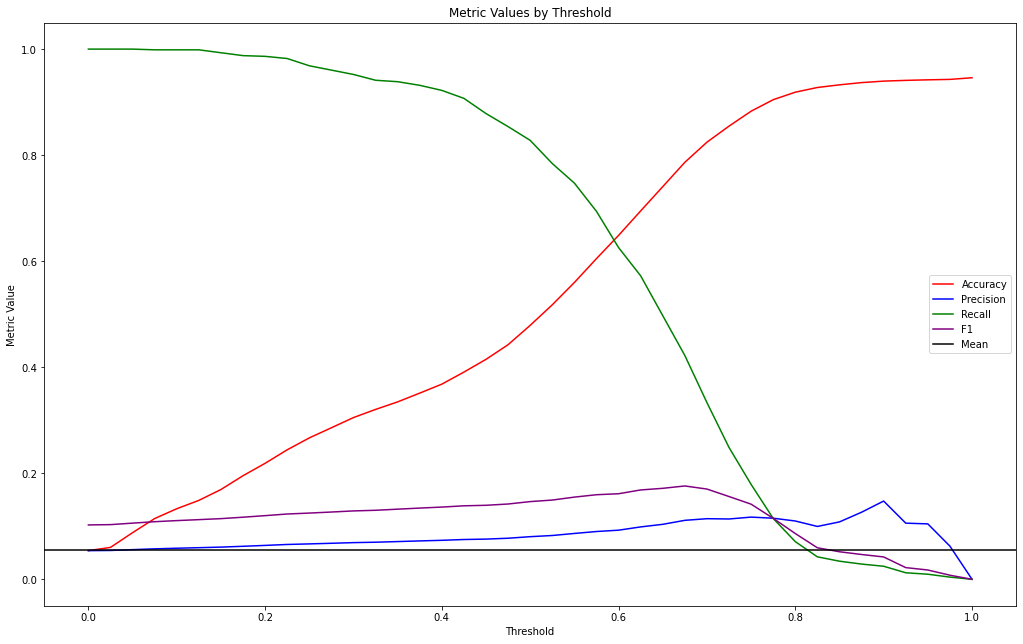

In [205]:
pl = plt.figure(figsize = (15,9))
ax = pl.add_axes([0.1,0.1,0.9,0.9])
ax.set_xlabel('Threshold')
ax.set_ylabel('Metric Value')
ax.set_title('Metric Values by Threshold')
ax.plot(metrics_df['index'],metrics_df['accuracy'], color = 'red', label = 'Accuracy')
ax.plot(metrics_df['index'],metrics_df['precision'], color = 'blue', label = 'Precision')
ax.plot(metrics_df['index'],metrics_df['recall'], color = 'green', label = 'Recall')
ax.plot(metrics_df['index'],metrics_df['f1'], color = 'purple', label = 'F1')
ax.axhline(y=fraud_rate_mean, color="black", label = 'Mean')
ax.legend()

Looking at the count of our confusion matrix, we see a similar trend. 
1. All values of the confusion matrix start to plateau past 0.7-0.8, and has the steepest gradients past 0.6, which means the optimal threshold value lies between 0.6 to 0.8.


2. Below the threshold value of 0.5, there were more Falsely classified samples than Correctly classified samples, indicated by the negative value of True Classified - False Classified = True False Difference [Black]. Any threshold values below 0.5 would yield a model that is highly inaccurate and not very useful for automating error detection.

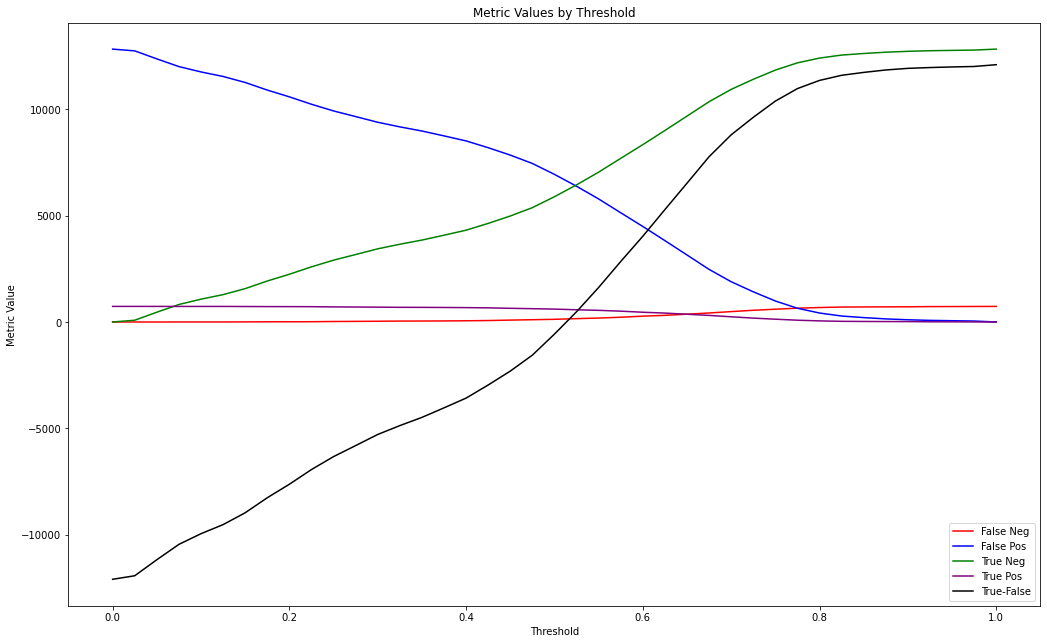

In [206]:
pl = plt.figure(figsize = (15,9))
ax = pl.add_axes([0.1,0.1,0.9,0.9])
ax.set_xlabel('Threshold')
ax.set_ylabel('Metric Value')
ax.set_title('Metric Values by Threshold')
ax.plot(confusion_df['index'],confusion_df['FN'], color = 'red', label = 'False Neg')
ax.plot(confusion_df['index'],confusion_df['FP'], color = 'blue', label = 'False Pos')
ax.plot(confusion_df['index'],confusion_df['TN'], color = 'green', label = 'True Neg')
ax.plot(confusion_df['index'],confusion_df['TP'], color = 'purple', label = 'True Pos')
ax.plot(confusion_df['index'],confusion_df['True False Difference'], color = 'black', label = 'True-False')
ax.legend()

In [207]:
print(confusion_matrix(target_test,y_pred_score,0.6))
print(confusion_matrix(target_test,y_pred_score,0.65))
print(confusion_matrix(target_test,y_pred_score,0.7))

{'TP': 458, 'TN': 8330, 'FP': 4487, 'FN': 274, 'True False Difference': 4027}
{'TP': 364, 'TN': 9670, 'FP': 3147, 'FN': 368, 'True False Difference': 6519}
{'TP': 244, 'TN': 10926, 'FP': 1891, 'FN': 488, 'True False Difference': 8791}


### Decision Tree

**Grid Search**

In [208]:
dpts = np.linspace(1,30,30).tolist()
criterion = []
confused_criterion = []
criterion_name = ['gini','entropy']
for i in range(2):
    met = {}
    confused = {}
    for dpt in dpts:
        dt = tree.DecisionTreeClassifier(criterion = criterion_name[i], 
                                         max_depth = dpt)
        dt.fit(x_data, target_train)
        y_pred_score = dt.predict(x_test)
        met[dpt] = {
          'f1': f1_score(target_test, y_pred_score),
          'accuracy': accuracy_score(target_test, y_pred_score),
          'precision': precision_score(target_test, y_pred_score),
          'recall': recall_score(target_test, y_pred_score),
          'auc': roc_auc_score(target_test, y_pred_score),
          }
        confused[dpt] = confusion_matrix(target_test, y_pred_score)
    criterion.append(met)
    confused_criterion.append(confused)
gini = pd.DataFrame(criterion[0]).transpose().reset_index()
entropy = pd.DataFrame(criterion[1]).transpose().reset_index()

**Accuracy Comparisons**

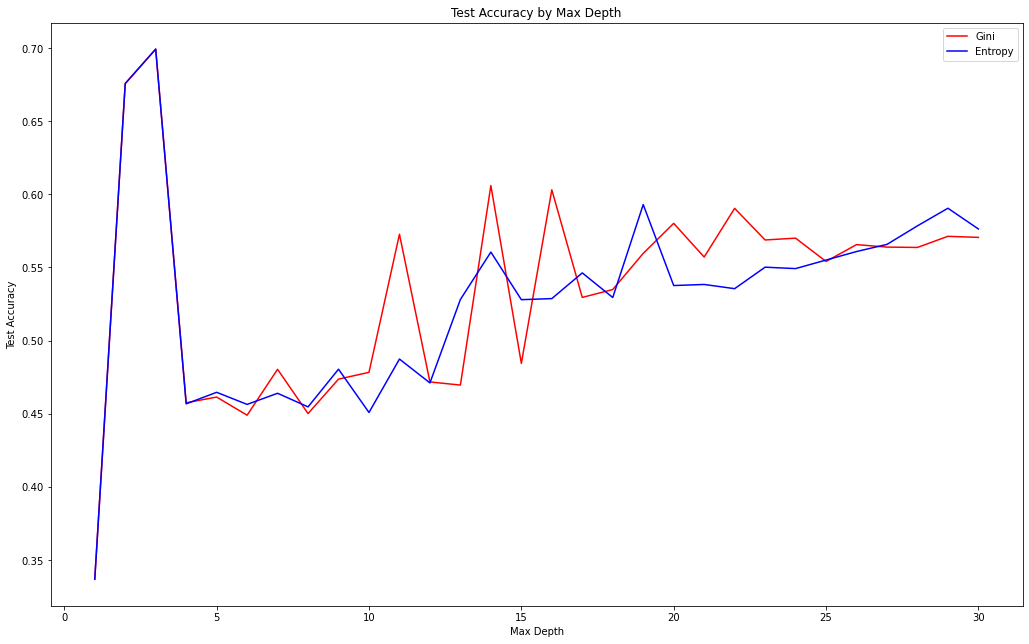

In [209]:
pl = plt.figure(figsize = (15,9))
ax = pl.add_axes([0.1,0.1,0.9,0.9])
ax.set_xlabel('Max Depth')
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy by Max Depth')
ax.plot(gini['index'],gini['accuracy'], color = 'red', label = 'Gini')
ax.plot(entropy['index'],entropy['accuracy'], color = 'blue', label = 'Entropy')
ax.legend()

**Recall Comparisons**

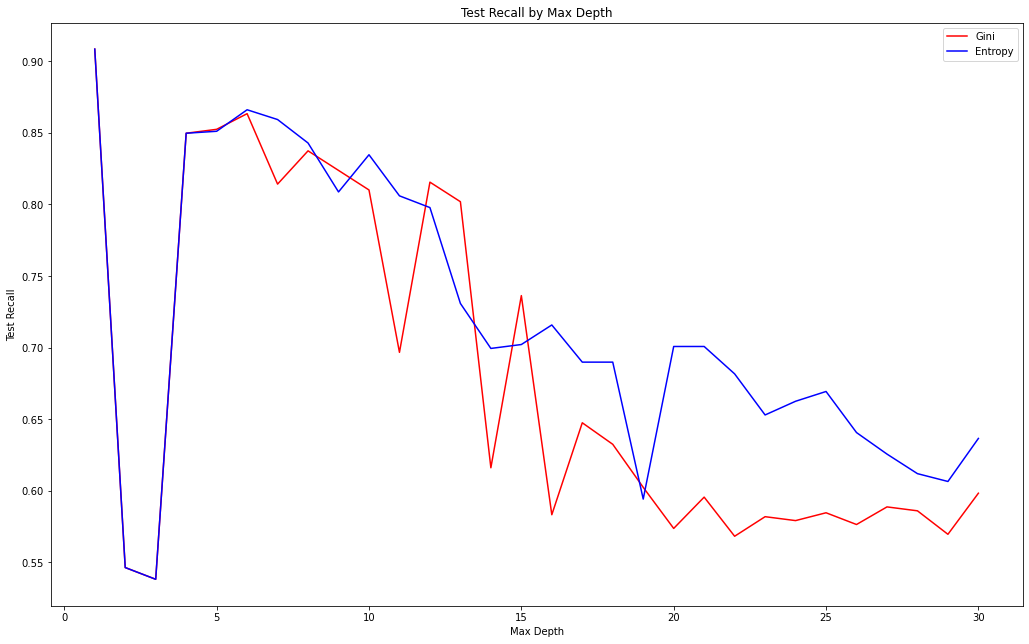

In [210]:
pl = plt.figure(figsize = (15,9))
ax = pl.add_axes([0.1,0.1,0.9,0.9])
ax.set_xlabel('Max Depth')
ax.set_ylabel('Test Recall')
ax.set_title('Test Recall by Max Depth')
ax.plot(gini['index'],gini['recall'], color = 'red', label = 'Gini')
ax.plot(entropy['index'],entropy['recall'], color = 'blue', label = 'Entropy')
ax.legend()

**Precision Comparisons**

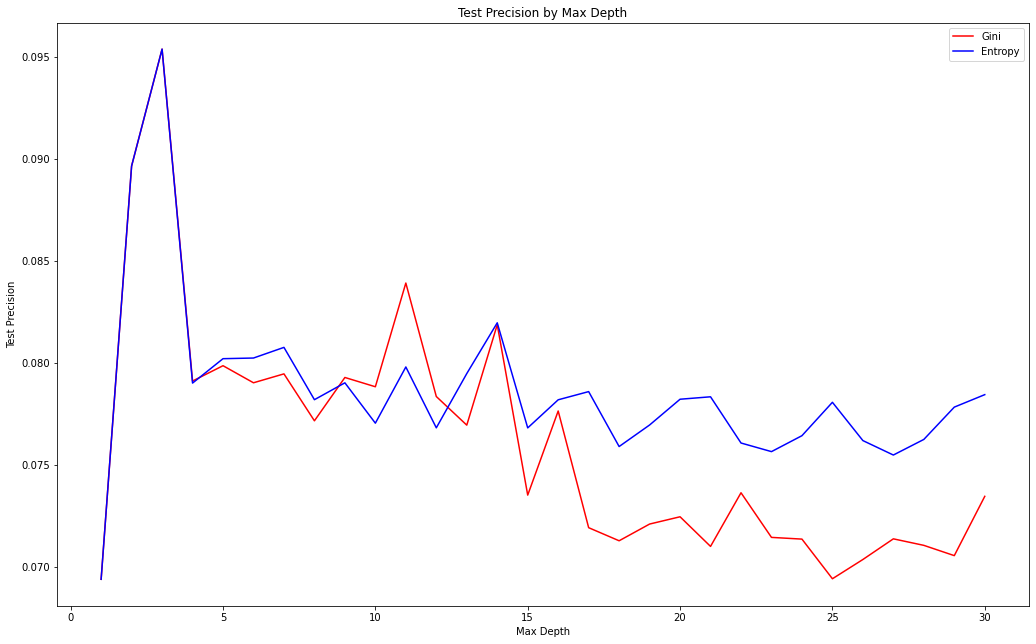

In [211]:
pl = plt.figure(figsize = (15,9))
ax = pl.add_axes([0.1,0.1,0.9,0.9])
ax.set_xlabel('Max Depth')
ax.set_ylabel('Test Precision')
ax.set_title('Test Precision by Max Depth')
ax.plot(gini['index'],gini['precision'], color = 'red', label = 'Gini')
ax.plot(entropy['index'],entropy['precision'], color = 'blue', label = 'Entropy')
ax.legend()

**F1 Comparisons**

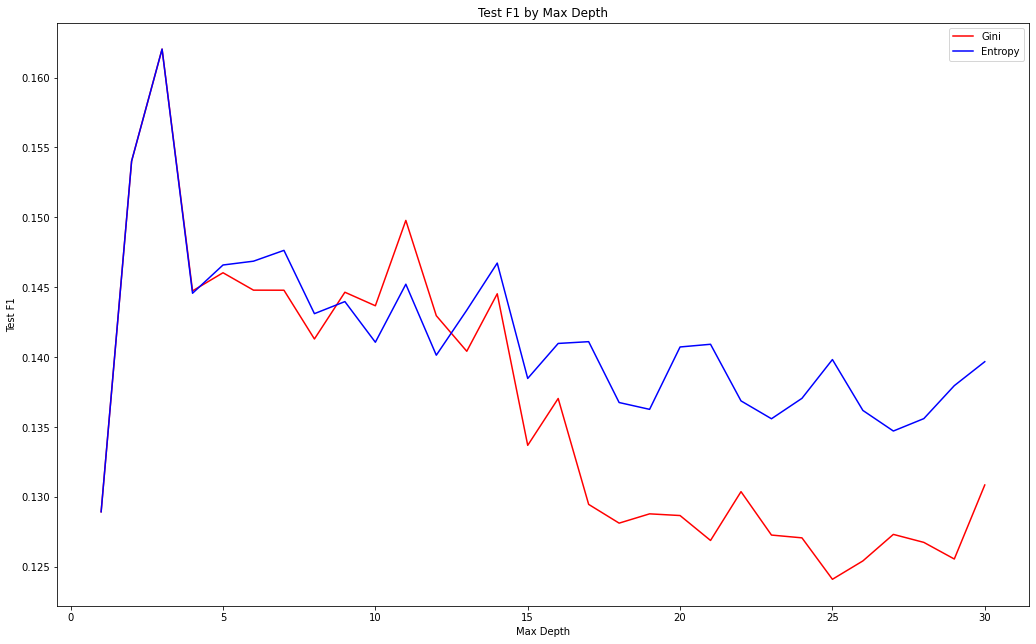

In [212]:
pl = plt.figure(figsize = (15,9))
ax = pl.add_axes([0.1,0.1,0.9,0.9])
ax.set_xlabel('Max Depth')
ax.set_ylabel('Test F1')
ax.set_title('Test F1 by Max Depth')
ax.plot(gini['index'],gini['f1'], color = 'red', label = 'Gini')
ax.plot(entropy['index'],entropy['f1'], color = 'blue', label = 'Entropy')
ax.legend()

**Entropy Metrics**

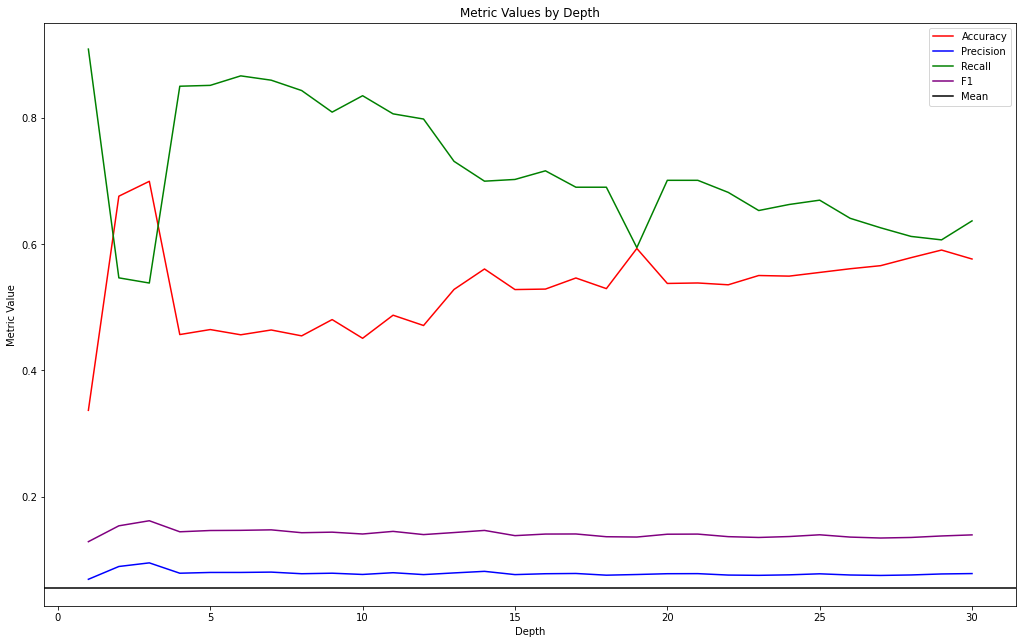

In [213]:
pl = plt.figure(figsize = (15,9))
ax = pl.add_axes([0.1,0.1,0.9,0.9])
ax.set_xlabel('Depth')
ax.set_ylabel('Metric Value')
ax.set_title('Metric Values by Depth')
ax.plot(entropy['index'],entropy['accuracy'], color = 'red', label = 'Accuracy')
ax.plot(entropy['index'],entropy['precision'], color = 'blue', label = 'Precision')
ax.plot(entropy['index'],entropy['recall'], color = 'green', label = 'Recall')
ax.plot(entropy['index'],entropy['f1'], color = 'purple', label = 'F1')
ax.axhline(y=fraud_rate_mean, color="black", label = 'Mean')
ax.legend()

In [214]:
dt = tree.DecisionTreeClassifier(criterion = 'entropy', 
                                     max_depth = 2)
dt.fit(x_data, target_train)
y_pred_score = dt.predict(x_test)
{
          'f1': f1_score(target_test, y_pred_score),
          'accuracy': accuracy_score(target_test, y_pred_score),
          'precision': precision_score(target_test, y_pred_score),
          'recall': recall_score(target_test, y_pred_score),
          'auc': roc_auc_score(target_test, y_pred_score),
          }

{'f1': 0.15402387370042356,
 'accuracy': 0.675695623293232,
 'precision': 0.08964589870013447,
 'recall': 0.546448087431694,
 'auc': 0.6147626252871975}

### Artificial Neural Network

In [223]:
met = {}
lyr = []
neurons = []
for i in range(100):
    l = random.randint(1,10)
    lyr.append(l)
    neurons_in_layer = []
    for layer in range(l):
        neurons_in_layer.append(random.randint(1,50))
    neurons.append(neurons_in_layer)
    
for i in range(100):
    layer_count = lyr[i]
    neurons_in_layer = neurons[i]
    # create sequential multi-layer perceptron
    ANN = keras.Sequential()
    # Input layer
    ANN.add(keras.Input(shape=x_data.shape[1]))

    for neuron in neurons_in_layer:
        ANN.add(layers.Dense(neuron ,activation = 'relu'))

    # Output layer
    ANN.add(layers.Dense(1, activation = 'sigmoid'))

    # Compile 
    ANN.compile(loss='binary_crossentropy', optimizer='adam')

    # Fit
    ANN.fit(x_data, target_train, batch_size=50, epochs=10, verbose=0)

    y_pred_score = ANN.predict(x_test)

    pred_binary = (y_pred_score > 0.5).astype(int)
    
    met[i] = {
      'f1': f1_score(target_test, pred_binary),
      'accuracy': accuracy_score(target_test, pred_binary),
      'precision': precision_score(target_test, pred_binary),
      'recall': recall_score(target_test, pred_binary),
      'auc': roc_auc_score(target_test, pred_binary),
        'layers': layer_count,
        'neurons': neurons_in_layer
      }


424/424 [==============================] - 0s 470us/step


C:\Users\Keltonn Lim\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


424/424 [==============================] - 0s 392us/step


In [224]:
ANN_results = pd.DataFrame(met).transpose().sort_values(by = 'f1', axis=0, ascending=False)
ANN_results

,f1,accuracy,precision,recall,auc,layers,neurons
26,0.159667,0.567274,0.089191,0.760929,0.658572,7,"[20, 38, 48, 21, 10, 39, 38]"
60,0.159189,0.540778,0.088332,0.804645,0.665176,10,"[43, 36, 33, 31, 39, 44, 48, 37, 50, 29]"
16,0.157307,0.560337,0.087739,0.759563,0.654261,1,[32]
13,0.156479,0.541664,0.086878,0.786885,0.657272,10,"[25, 43, 31, 35, 40, 15, 18, 3, 41, 11]"
65,0.15642,0.50882,0.086209,0.842896,0.666318,2,"[23, 1]"
...,...,...,...,...,...,...,...
77,0.137861,0.377814,0.074508,0.920765,0.633785,8,"[11, 44, 10, 2, 24, 28, 36, 22]"
76,0.129761,0.311979,0.069639,0.949454,0.612513,6,"[1, 46, 46, 44, 20, 29]"
84,0.102514,0.054026,0.054026,1.0,0.5,9,"[22, 22, 2, 40, 1, 36, 14, 31, 13]"
83,0.102514,0.054026,0.054026,1.0,0.5,7,"[47, 46, 2, 5, 4, 1, 3]"


**Model Complexity Evalutation**

We plotted scatterplots of Model Layers effect on various model performance metrics. Generally, all models performed similarly regardless of complexity or architecture, with the exception of a few underperforming outliers.

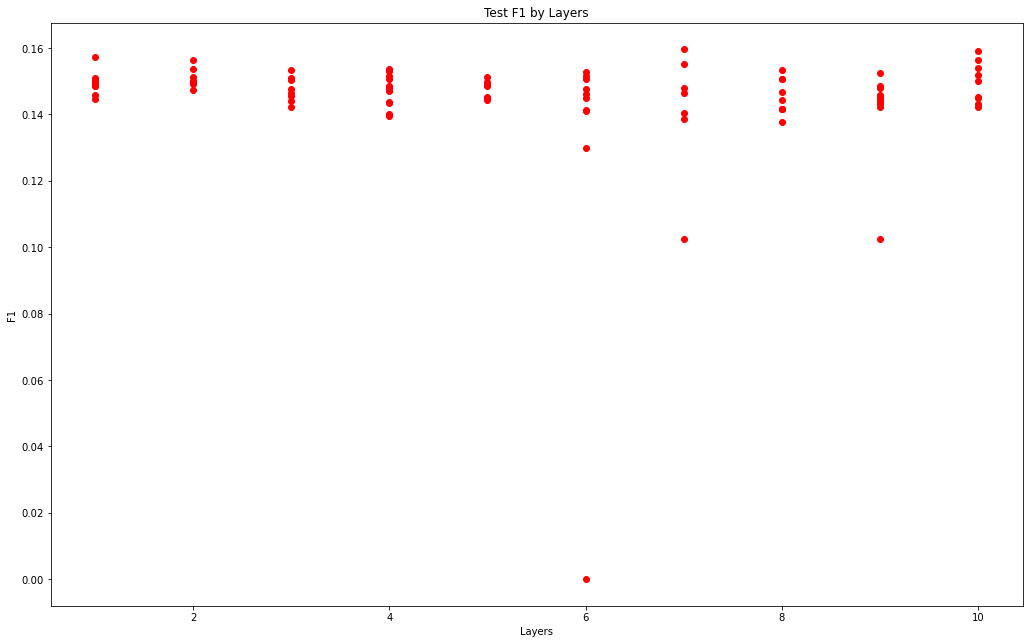

In [225]:
pl = plt.figure(figsize = (15,9))
ax = pl.add_axes([0.1,0.1,0.9,0.9])
ax.set_xlabel('Layers')
ax.set_ylabel('F1')
ax.set_title('Test F1 by Layers')
ax.scatter(ANN_results['layers'],ANN_results['f1'], color = 'red')

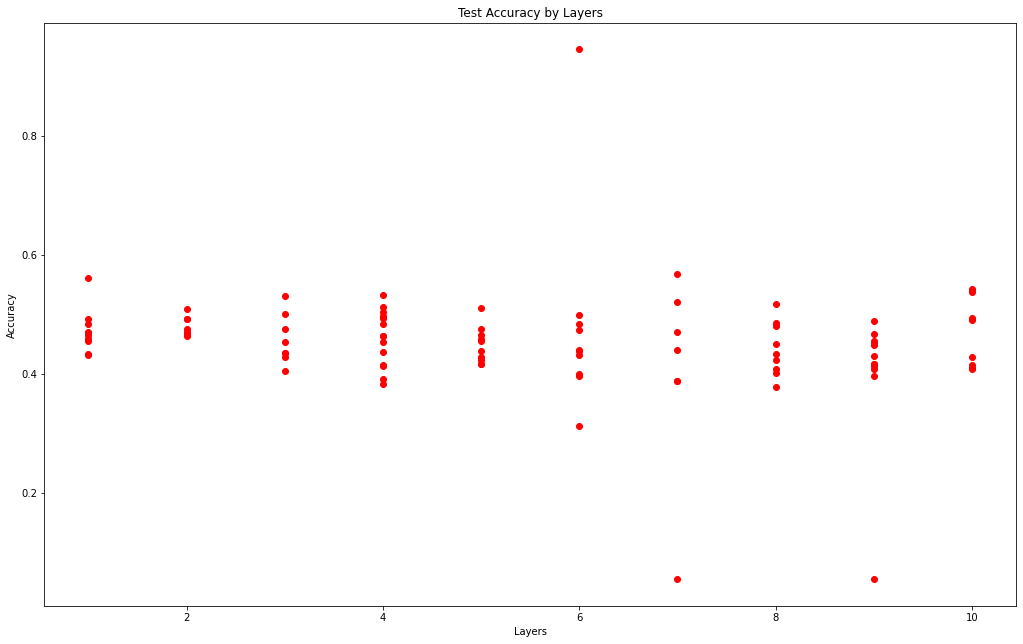

In [226]:
pl = plt.figure(figsize = (15,9))
ax = pl.add_axes([0.1,0.1,0.9,0.9])
ax.set_xlabel('Layers')
ax.set_ylabel('Accuracy')
ax.set_title('Test Accuracy by Layers')
ax.scatter(ANN_results['layers'],ANN_results['accuracy'], color = 'red')

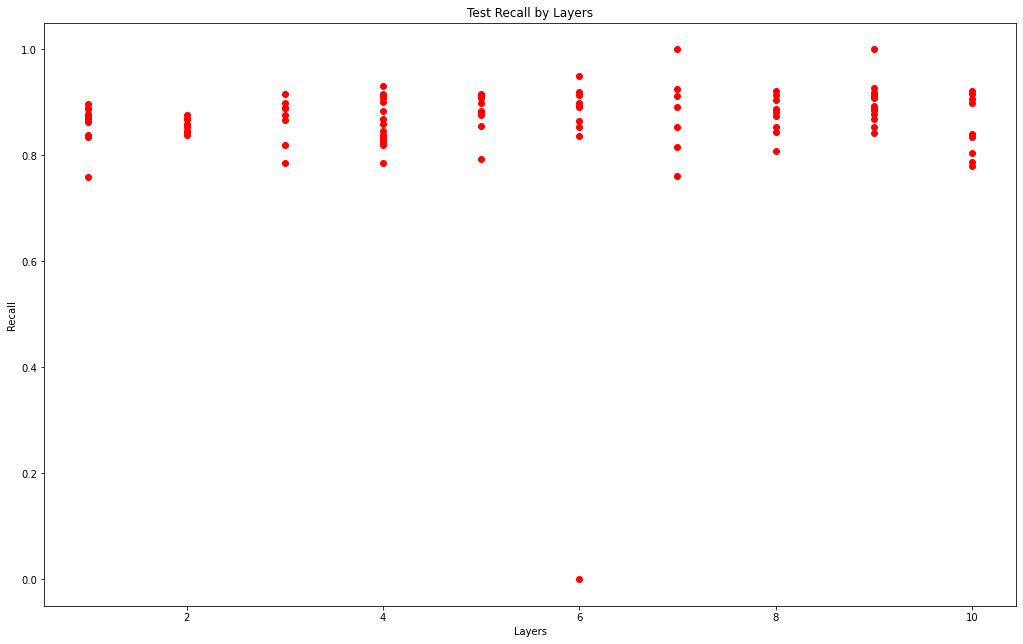

In [227]:
pl = plt.figure(figsize = (15,9))
ax = pl.add_axes([0.1,0.1,0.9,0.9])
ax.set_xlabel('Layers')
ax.set_ylabel('Recall')
ax.set_title('Test Recall by Layers')
ax.scatter(ANN_results['layers'],ANN_results['recall'], color = 'red')

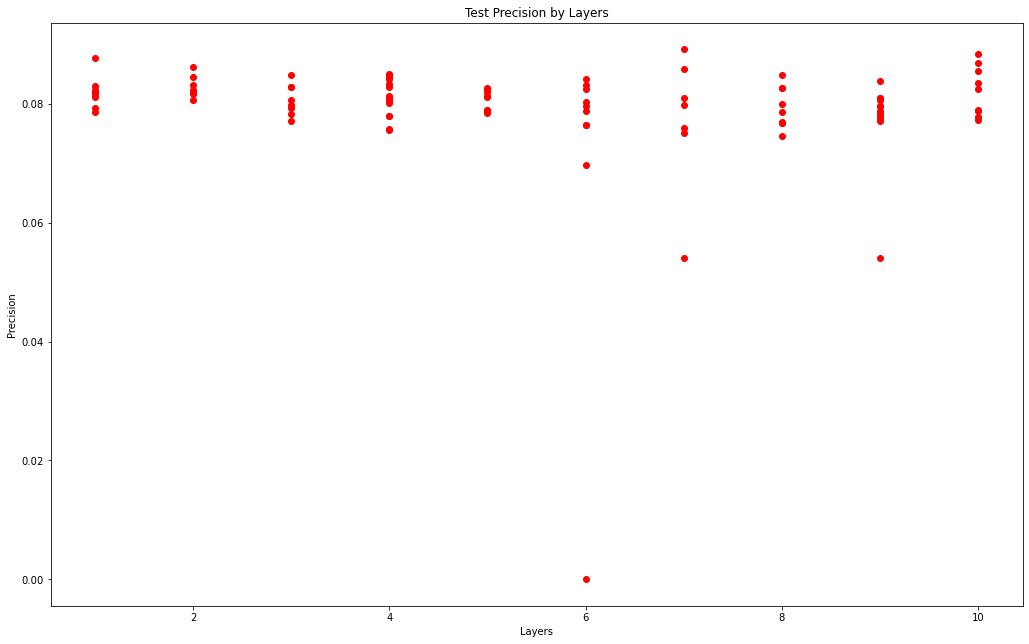

In [228]:
pl = plt.figure(figsize = (15,9))
ax = pl.add_axes([0.1,0.1,0.9,0.9])
ax.set_xlabel('Layers')
ax.set_ylabel('Precision')
ax.set_title('Test Precision by Layers')
ax.scatter(ANN_results['layers'],ANN_results['precision'], color = 'red')

### Final Validation

**Logistic Regression**: Threshold = 0.62

**Decision Tree**: Max Depth = 2, Error = 'entropy'
      
**ANN**: Single Hidden Layer, ReLU, 32 Neurons
 
Retrain with Test + Train data, then evaluate on validation set.

In [229]:
# Merge Train and Test Set
train_test_merged = pd.concat([input_train, input_test])

# Rebalance Dataset
honest_clients = train_test_merged[train_test_merged['target']==0]
fraud_clients = train_test_merged[train_test_merged['target']==1]
honest_sample = honest_clients.copy().sample(fraud_clients.shape[0])
balanced_clients = pd.concat([honest_sample, fraud_clients.copy()])

# Initialise Target and input matrices
usable_columns = [col for col in input_train.columns if col not in ['target','client_id']]
target_column = 'target'
x_data, target_train = balanced_clients[usable_columns], balanced_clients[target_column]
x_val, target_val = input_val[usable_columns], input_val[target_column]

In [230]:
# Initialise Logistic Regression Model
logistic_reg = LogisticRegression(max_iter = 1000000)
logistic_reg.fit(x_data, target_train)
y_pred_score = logistic_reg.predict_proba(x_val)[:,1]

get_metric(target_val, y_pred_score, threshold=0.62)

{'f1': 0.17459987528580334,
 'accuracy': 0.7069372693726937,
 'precision': 0.10337189269013045,
 'recall': 0.5614973262032086,
 'auc': 0.7079447186978639}

In [231]:
# Decision Tree
dt = tree.DecisionTreeClassifier(criterion = 'entropy', 
                                     max_depth = 2)
dt.fit(x_data, target_train)
y_pred_score = dt.predict(x_val)
{
      'f1': f1_score(target_val, y_pred_score),
      'accuracy': accuracy_score(target_val, y_pred_score),
      'precision': precision_score(target_val, y_pred_score),
      'recall': recall_score(target_val, y_pred_score),
      'auc': roc_auc_score(target_val, y_pred_score),
  }


{'f1': 0.1574712643678161,
 'accuracy': 0.6754243542435424,
 'precision': 0.0919051878354204,
 'recall': 0.5494652406417112,
 'auc': 0.6161245903255423}

In [232]:
num_epochs = 10
x_data = np.asarray(x_data).astype('float32')

# create sequential multi-layer perceptron
ANN = keras.Sequential()
# Input layer
ANN.add(keras.Input(shape=x_data.shape[1]))

# layer 1
ANN.add(layers.Dense(32 ,activation = 'relu'))
# Output layer
ANN.add(layers.Dense(1, activation = 'sigmoid'))

# Compile 
ANN.compile(loss='binary_crossentropy', optimizer='adam')

# Fit
ANN.fit(x_data, target_train, batch_size=50, epochs=num_epochs, verbose=0)

y_pred_score = ANN.predict(x_val)

get_metric(target_val, y_pred_score, threshold=0.5)

424/424 [==============================] - 0s 359us/step


{'f1': 0.14808105966262877,
 'accuracy': 0.4446494464944649,
 'precision': 0.08089053803339517,
 'recall': 0.8743315508021391,
 'auc': 0.7083318365195277}

### Investigating Significant Features

In [235]:
shap.initjs()

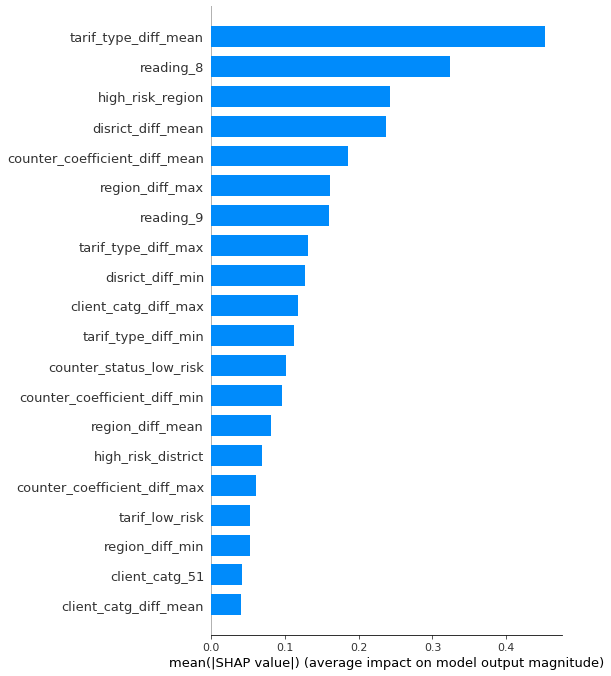

In [236]:
explainer = shap.LinearExplainer(logistic_reg, x_data, feature_perturbation="interventional")
shap_values = explainer.shap_values(x_data)
shap.summary_plot(shap_values, x_data,
                  feature_names=usable_columns,
                  sort=True, plot_type="bar")